# FN6809 Linear Financial Models
**Group 9** Members:<br><br>
HU ZIHAO<br>
KONG FANJI<br>
SHI XUEER<br>
XU SHUMING<br>
ZHOU XUAN

## 1. Data Exploratory

### 1.1 Loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kruskal
from scipy.stats import f  # Use scipy's F-distribution for partial F-test

import re
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from itertools import combinations
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

# import importlib
# import linear_utils
# importlib.reload(linear_utils)
from linear_utils import *
import gc


In [2]:
df = pd.read_csv("used_cars.csv")
df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714 mi.,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,"$349,950"
4005,Audi,S4 3.0T Premium Plus,2022,"10,900 mi.",Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,"$53,900"
4006,Porsche,Taycan,2022,"2,116 mi.",NaN,Electric,Automatic,Black,Black,None reported,NaN,"$90,998"
4007,Ford,F-150 Raptor,2020,"33,000 mi.",Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,"$62,999"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


Although *model_year* is the only numerical feature, *milage* and *price* are supposed to be in numerical format as well.

In [4]:
df['milage'] = df['milage'].replace(to_replace=r',', value='', regex=True)   # Remove commas
df['milage'] = df['milage'].replace(to_replace=r' mi\.', value='', regex=True)  # Remove ' mi.' suffix
df['milage'] = pd.to_numeric(df['milage'], errors='coerce').astype(float)  # Convert to numeric type, coercing invalid data to NaN
df['milage']

0       51000.0
1       34742.0
2       22372.0
3       88900.0
4        9835.0
         ...   
4004      714.0
4005    10900.0
4006     2116.0
4007    33000.0
4008    43000.0
Name: milage, Length: 4009, dtype: float64

In [5]:
df['price'] = df['price'].replace(to_replace=r'\$', value='', regex=True)   # Remove the dollar sign
df['price'] = df['price'].replace(to_replace=r',', value='', regex=True)    # Remove commas
df['price'] = pd.to_numeric(df['price'], errors='coerce').astype(float)  # Convert to numeric type, coercing invalid data to NaN
df['price']

0        10300.0
1        38005.0
2        54598.0
3        15500.0
4        34999.0
          ...   
4004    349950.0
4005     53900.0
4006     90998.0
4007     62999.0
4008     40000.0
Name: price, Length: 4009, dtype: float64

### 1.2 Data Summary

A basic description of numerical features of the dataset

In [6]:
df.describe()

,model_year,milage,price
count,4009.000000,4009.000000,4.009000e+03
mean,2015.515590,64717.551010,4.455319e+04
std,6.104816,52296.599459,7.871064e+04
min,1974.000000,100.000000,2.000000e+03
25%,2012.000000,23044.000000,1.720000e+04
50%,2017.000000,52775.000000,3.100000e+04
75%,2020.000000,94100.000000,4.999000e+04
max,2024.000000,405000.000000,2.954083e+06


A basic description of categorical features of the dataset

In [7]:
df.describe(include=['object', 'category'])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,4009,4009,3839,4009,4009,4009,4009,3896,3413
unique,57,1898,7,1146,62,319,156,2,1
top,Ford,M3 Base,Gasoline,2.0L I4 16V GDI DOHC Turbo,A/T,Black,Black,None reported,Yes
freq,386,30,3309,52,1037,905,2025,2910,3413


<a id='null'></a>
### 1.3 Analysis of Null Values

In [8]:
missing = df.isnull().sum().reset_index()
missing.columns = ['Features','Missing_Count']
missing['%Missing'] = missing['Missing_Count']/df.shape[0]*100
missing[missing['Missing_Count']>0]

,Features,Missing_Count,%Missing
4,fuel_type,170,4.240459
9,accident,113,2.818658
10,clean_title,596,14.866550


Apparently, the dataset only has 3 features with null values. Next, each of 3 features/predictors will be examined to extract potentailly useful insights.

In [9]:
# Analysing fuel_type
df_fuel = df.copy()
df_fuel['fuel_type'] = df_fuel['fuel_type'].fillna('NA')
df_fuel.groupby('fuel_type')['price'].median().reset_index().sort_values(by='price', ascending=True)

,fuel_type,price
6,not supported,14000.0
7,–,15300.0
1,E85 Flex Fuel,19500.0
2,Gasoline,29950.0
5,Plug-In Hybrid,44945.0
0,Diesel,45450.0
3,Hybrid,45499.0
4,NA,46999.0


In [10]:
df.iloc[df_fuel[df_fuel['fuel_type'] == 'NA'].index].sample(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
3649,Volkswagen,ID.4 Pro S,2023,1716.0,NaN,Battery Electric,Automatic,Gray,Gray w/Blue Bolsters,None reported,NaN,39998.0
1330,Rivian,R1S Adventure Package,2023,1150.0,NaN,835.0HP Electric Motor Electric Fuel System,A/T,Green,Black,None reported,Yes,96850.0
3255,BMW,i3 Base,2015,26000.0,NaN,170.0HP 0.65L Electric Motor Electric Fuel System,1-Speed A/T,White,Beige,None reported,Yes,14999.0
3425,Tesla,Model X Plaid,2022,15000.0,NaN,1020.0HP Electric Motor Electric Fuel System,A/T,White,White,None reported,Yes,95999.0
753,FIAT,500e Battery Electric,2017,33812.0,NaN,111.0HP Electric Motor Electric Fuel System,1-Speed A/T,Silver,Black,None reported,Yes,14999.0
2116,Tesla,Model S P100D,2017,103000.0,NaN,Electric Motor Electric Fuel System,1-Speed A/T,Black,White,None reported,Yes,36000.0
122,Rivian,R1S Adventure Package,2023,2500.0,NaN,835.0HP Electric Motor Electric Fuel System,A/T,Green,White,None reported,Yes,94000.0
236,Polestar,2 Launch Edition,2021,12172.0,NaN,Electric,1-Speed Automatic,Thunder Gray,Charcoal,None reported,NaN,35999.0
2451,Tesla,Model S Long Range,2021,35315.0,NaN,670.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Black,None reported,Yes,66900.0
253,Mercedes-Benz,EQS 450 4MATIC,2023,7388.0,NaN,355.0HP Electric Motor Electric Fuel System,1-Speed A/T,Gray,Beige,None reported,Yes,105500.0


**Insights:**<br><br>
It’s notable that missing fuel type ('NA') has one of the highest median prices (46,999), which could indicate that this data is missing not randomly. Perhaps luxury or higher-end vehicles are more likely to have incomplete data for some reason, or it could be that this field was omitted for certain vehicles due to data entry issues. Thus, null values shoule be treated as a new category.


In [11]:
# Analysing accident
df_accident = df.copy()
df_accident['accident'] = df_accident['accident'].fillna('NA')
df_accident.groupby('accident')['price'].median().reset_index().sort_values(by='price',ascending = True)

,accident,price
0,At least 1 accident or damage reported,20900.0
2,None reported,35667.5
1,NA,36500.0


In [12]:
df.iloc[df_accident[df_accident['accident'] == 'NA'].index].sample(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
2328,Cadillac,Escalade ESV Platinum Edition,2013,119000.0,E85 Flex Fuel,403.0HP 6.2L 8 Cylinder Engine Flex Fuel Capab...,A/T,Black,Black,NaN,NaN,20500.0
3031,GMC,Sierra 2500 AT4,2022,22600.0,Diesel,6.6L V8 32V DDI OHV Turbo Diesel,Automatic,Ebony Twilight Metallic,Jet Black,NaN,NaN,76740.0
1635,Chevrolet,Silverado 3500 LTZ,2018,92149.0,Diesel,6.6L V8 32V DDI OHV Turbo Diesel,6-Speed Automatic,Black,Jet Black,NaN,NaN,52889.0
2368,Chevrolet,Silverado 1500 LT,2019,36021.0,Gasoline,2.7L I4 16V GDI DOHC Turbo,Automatic,Cajun Red Tintcoat,Jet Black,NaN,NaN,35670.0
1970,Land,Rover Defender 110 SE,2020,29700.0,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Green,Black,NaN,NaN,68000.0


In [13]:
df['accident'].unique()

array(['At least 1 accident or damage reported', 'None reported', nan],
      dtype=object)

**Insights:**<br><br>
The median price for entries marked as 'NA' is 36,500, which is close to the "None reported" category. This indicates that vehicles with missing accident information are still perceived similarly to those without reported accidents, suggesting that feature *accident* of these vehicles could be treated as "None reported".

In [14]:
df_clean_title = df.copy()
df_clean_title['clean_title'] = df_clean_title['clean_title'].fillna('NA')
df_clean_title.groupby('clean_title')['price'].median().reset_index().sort_values(by='price',ascending = True)

,clean_title,price
1,Yes,29000.0
0,NA,42996.5


**Insights:**<br><br>
The NA values for clean_title also have a significantly higher median price and will be treated as a separate category.

### 1.4 Outlier Detection

#### 1.4.1 Price

<Axes: xlabel='price'>

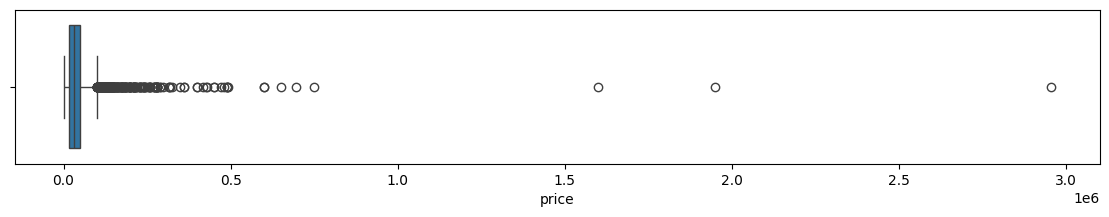

In [15]:
plt.figure(figsize=(14,2))

sns.boxplot(df.price,orient='h')

In [16]:
outlier_data = df.copy()

iqr = outlier_data.price.quantile(.75) - outlier_data.price.quantile(0.25)
l_limit = outlier_data.price.quantile(0.25) - iqr*1.5
u_limit = outlier_data.price.quantile(0.75) + iqr*1.5

indx = outlier_data[(outlier_data.price<l_limit) | (outlier_data.price>u_limit)].index
print(len(indx), f'Outliers Detected Using IQR({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
     f'\t\t| Price at Upper Limit: {u_limit}')

for i in range(10):
    u_limit = outlier_data.price.quantile(0.90+i/100)
    indx = outlier_data[(outlier_data.price>u_limit)].index
    print(len(indx),
          f'Outliers Detected Using {0.9*100+i} percentile({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
         f'\t| Price at {0.9*100+i} percentile: {outlier_data.price.quantile(0.9+i/100)}')


244 Outliers Detected Using IQR(6.09%) 		| Price at Upper Limit: 99175.0
399 Outliers Detected Using 90.0 percentile(9.95%) 	| Price at 90.0 percentile: 79999.0
361 Outliers Detected Using 91.0 percentile(9.0%) 	| Price at 91.0 percentile: 84627.0
318 Outliers Detected Using 92.0 percentile(7.93%) 	| Price at 92.0 percentile: 89000.0
280 Outliers Detected Using 93.0 percentile(6.98%) 	| Price at 93.0 percentile: 93999.0
241 Outliers Detected Using 94.0 percentile(6.01%) 	| Price at 94.0 percentile: 99852.0
201 Outliers Detected Using 95.0 percentile(5.01%) 	| Price at 95.0 percentile: 111599.99999999991
158 Outliers Detected Using 96.0 percentile(3.94%) 	| Price at 96.0 percentile: 129000.0
121 Outliers Detected Using 97.0 percentile(3.02%) 	| Price at 97.0 percentile: 149803.9999999999
81 Outliers Detected Using 98.0 percentile(2.02%) 	| Price at 98.0 percentile: 197099.16000000035
41 Outliers Detected Using 99.0 percentile(1.02%) 	| Price at 99.0 percentile: 272713.2800000002


*94.0 percentile could be used as a threshold for mapping the outliers' values (i.e. all outliers' values converted to 94.0 percentile)*

#### 1.4.2 Milage

<Axes: xlabel='milage'>

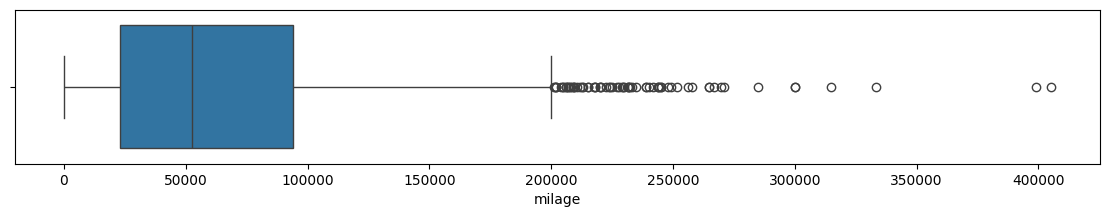

In [17]:
plt.figure(figsize=(14,2))

sns.boxplot(df.milage,orient='h')

In [18]:
outlier_data = df.copy()

iqr = outlier_data.milage.quantile(.75) - outlier_data.milage.quantile(0.25)
l_limit = outlier_data.milage.quantile(0.25) - iqr*1.5
u_limit = outlier_data.milage.quantile(0.75) + iqr*1.5

indx = outlier_data[(outlier_data.milage<l_limit) | (outlier_data.milage>u_limit)].index
print(len(indx), f'Outliers Detected Using IQR({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
     f'\t\t| Milage at Upper Limit: {u_limit}')


for i in range(6):
    u_limit = outlier_data.milage.quantile(0.95+i/100)
    indx = outlier_data[(outlier_data.milage>u_limit)].index
    print(len(indx),
          f'Outliers Detected Using {0.95*100+i} percentile({round(len(indx)/outlier_data.shape[0]*100,2)}%)',
         f'\t| Price at {0.95*100+i} percentile: {outlier_data.milage.quantile(0.95+i/100)}')

69 Outliers Detected Using IQR(1.72%) 		| Milage at Upper Limit: 200684.0
200 Outliers Detected Using 95.0 percentile(4.99%) 	| Price at 95.0 percentile: 165000.0
161 Outliers Detected Using 96.0 percentile(4.02%) 	| Price at 96.0 percentile: 171535.27999999988
118 Outliers Detected Using 97.0 percentile(2.94%) 	| Price at 97.0 percentile: 185000.0
81 Outliers Detected Using 98.0 percentile(2.02%) 	| Price at 98.0 percentile: 195477.76
41 Outliers Detected Using 99.0 percentile(1.02%) 	| Price at 99.0 percentile: 222428.00000000015
0 Outliers Detected Using 100.0 percentile(0.0%) 	| Price at 100.0 percentile: 405000.0


Since only less than 2% of records' milage are identified as outliers,we could simply drop them or mapping them to iqr*1.5+0.75 quantile

### 1.5 Numerical Features Analysis

#### 1.5.1 Visualizations of Numerical Variables

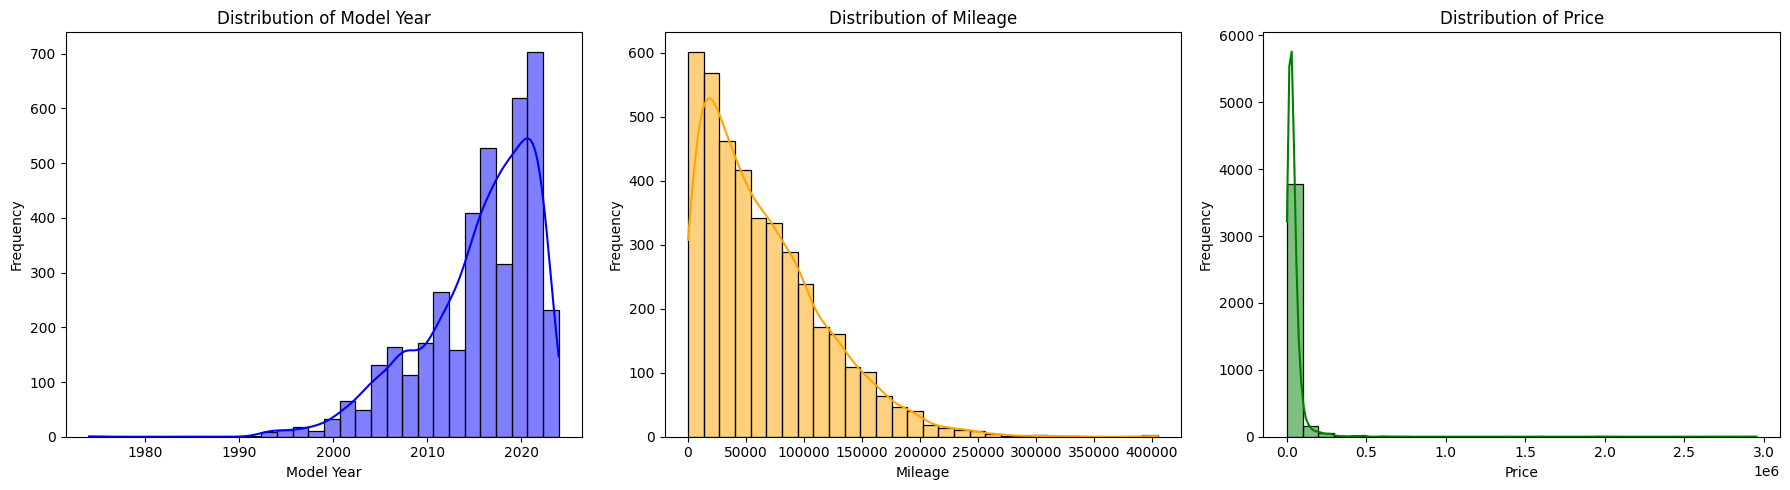

In [19]:
# Create a figure for the histograms
plt.figure(figsize=(18, 5))

# Histogram for model_year
plt.subplot(1, 3, 1)
sns.histplot(df['model_year'], bins=30, kde=True, color='blue')
plt.title('Distribution of Model Year')
plt.xlabel('Model Year')
plt.ylabel('Frequency')

# Histogram for mileage
plt.subplot(1, 3, 2)
sns.histplot(df['milage'], bins=30, kde=True, color='orange')
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')

# Histogram for price
plt.subplot(1, 3, 3)
sns.histplot(df['price'], bins=30, kde=True, color='green')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

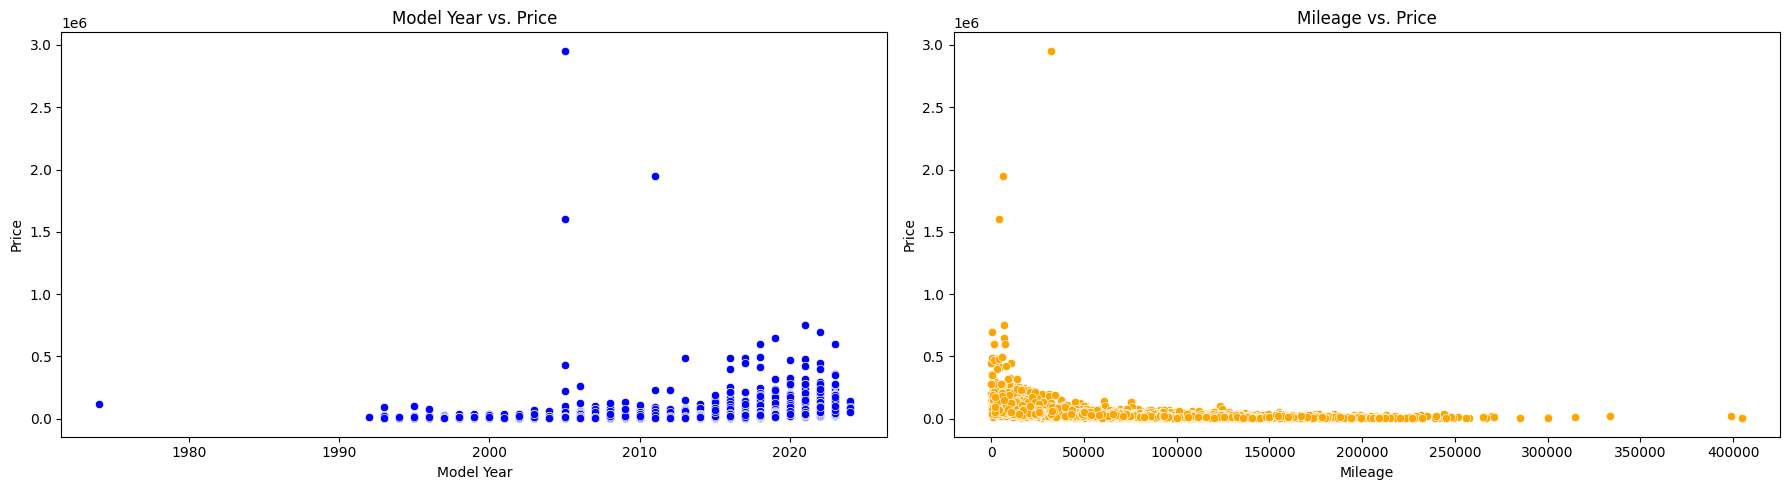

In [20]:
# Create a figure for the scatter plots
plt.figure(figsize=(18, 5))

# Scatter plot for model_year vs price
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='model_year', y='price', color='blue')
plt.title('Model Year vs. Price')
plt.xlabel('Model Year')
plt.ylabel('Price')

# Scatter plot for mileage vs price
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='milage', y='price', color='orange')
plt.title('Mileage vs. Price')
plt.xlabel('Mileage')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

#### 1.5.2 Correlation Analysis

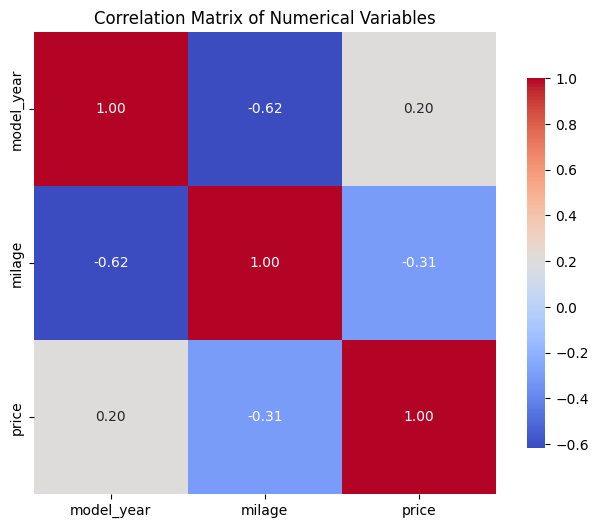

In [21]:
correlation_matrix = df[['model_year', 'milage', 'price']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### 1.6 Categorical Features Analysis

#### 1.6.1 Brand

In [22]:
# Analysing brand
brand_df = df.groupby('brand')['price'].agg(['count','mean','median','min','max']).reset_index()
brand_df['count%'] = brand_df['count']/df.shape[0]*100
brand_df.sort_values(by='count',ascending=False).reset_index(drop=True)

,brand,count,mean,median,min,max,count%
0,Ford,386,3.624088e+04,32377.5,3000.0,429998.0,9.628336
1,BMW,375,4.107231e+04,32999.0,2500.0,145000.0,9.353954
2,Mercedes-Benz,315,5.207577e+04,38598.0,4750.0,425000.0,7.857321
3,Chevrolet,292,3.672274e+04,31992.5,4000.0,179000.0,7.283612
4,Porsche,201,8.875130e+04,59900.0,8500.0,1599000.0,5.013719
5,Audi,200,3.990743e+04,34497.5,5500.0,187900.0,4.988775
6,Toyota,199,3.002600e+04,27999.0,2500.0,91995.0,4.963831
7,Lexus,163,3.566852e+04,30000.0,3500.0,159000.0,4.065852
8,Jeep,143,3.109979e+04,30000.0,4500.0,84620.0,3.566974
9,Land,130,5.576406e+04,44924.0,5750.0,199998.0,3.242704


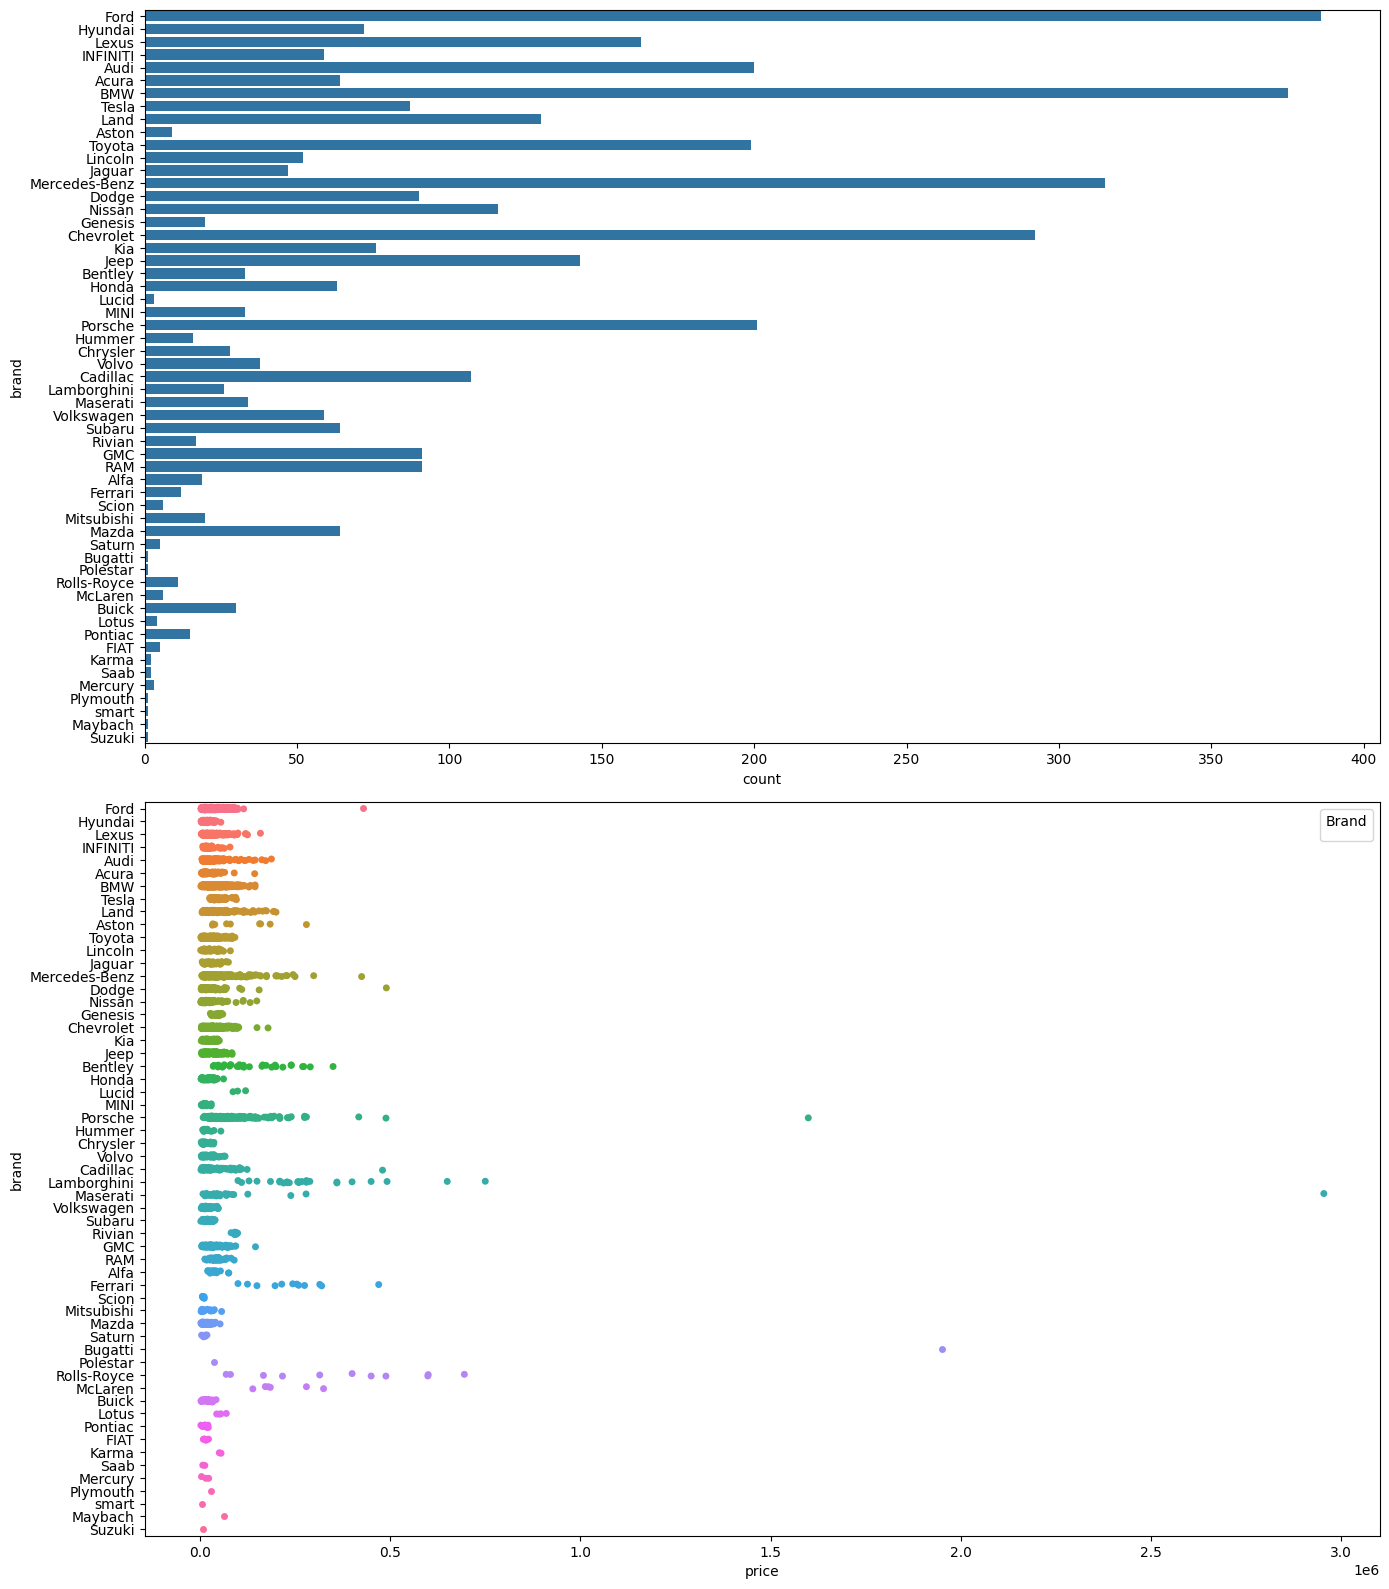

In [23]:
plt.figure(figsize=(14, 16))

# Horizontal countplot
plt.subplot(211)
sns.countplot(y=df['brand'])  # Changed x to y for horizontal orientation
# plt.xticks(rotation=45)  # This might not be necessary for a horizontal plot

plt.subplot(212)
sns.stripplot(y=df['brand'], x=df['price'], hue=df['brand'], jitter=True)  # Switched x and y
# plt.xticks(rotation=45)
plt.legend([], title='Brand')  # Optional: Add a title for clarity

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

In [24]:
grp = [val.values for name,val in df.groupby('brand')['price']]
print(kruskal(*grp))

KruskalResult(statistic=np.float64(992.1679282337675), pvalue=np.float64(2.092814239885586e-171))


**Purpose of the Kruskal-Wallis Test** <br><br>
Hypothesis Testing: The Kruskal-Wallis H test is a non-parametric test used to determine if there are statistically significant differences between the medians of three or more independent groups. These groups are defined by the different brand categories for this study.

*H0: All group medians are equal (i.e., there is no difference in car prices across different brands).*

*Ha: At least one group median is different.*

**Insights:**<br><br>
Few brands have higher means and median and can be consider luxury brands (e.g. Ferrari, Rolls Royals, Lamborgini, etc)


#### 1.6.2 Model

In [25]:
# Analysing model
print('Total Unique Model:',df.model.nunique())
model_df = df.groupby('model')['price'].agg(['count','mean','median','std','min','max']).reset_index()
model_df['count%'] = model_df['count']/df.shape[0]*100
model_df.sort_values(by='count',ascending=False).reset_index(drop=True).head(10)

Total Unique Model: 1898


,model,count,mean,median,std,min,max,count%
0,M3 Base,30,35322.400000,30499.5,15184.132456,15000.0,84645.0,0.748316
1,F-150 XLT,24,36340.708333,35997.0,9651.287332,15000.0,58504.0,0.598653
2,Corvette Base,22,26390.227273,27250.0,9077.846199,9900.0,39500.0,0.548765
3,1500 Laramie,18,46542.500000,46799.0,3246.195968,34918.0,51074.0,0.448990
4,Model Y Long Range,17,45129.117647,46500.0,5825.925601,35500.0,56515.0,0.424046
5,Camaro 2SS,17,38167.647059,39000.0,10493.911050,19500.0,54900.0,0.424046
6,Wrangler Sport,17,21903.705882,22000.0,9170.622380,5500.0,40995.0,0.424046
7,Mustang GT Premium,16,30886.875000,29745.0,9727.642207,18500.0,49500.0,0.399102
8,911 Carrera,16,93339.875000,102946.5,35614.980290,35000.0,149000.0,0.399102
9,M4 Base,15,57909.066667,60995.0,12240.041202,32999.0,81000.0,0.374158


In [26]:
unique_model_df = df.groupby('brand')['model'].nunique().reset_index()
unique_model_df.sort_values(by='model',ascending=False).reset_index(drop=True)

,brand,model
0,BMW,145
1,Ford,142
2,Mercedes-Benz,130
3,Audi,118
4,Chevrolet,116
5,Toyota,98
6,Land,72
7,Porsche,71
8,Nissan,62
9,Cadillac,56


#### 1.6.3 Fuel Type

In [27]:
# Analysing fuel type
fuel_data = df.copy()
fuel_data['fuel_type'] = fuel_data.fuel_type.fillna('NA')

fuel_df = fuel_data.groupby(['fuel_type'])['price'].agg(['count','mean','median','std','min','max']).reset_index()
fuel_df

,fuel_type,count,mean,median,std,min,max
0,Diesel,116,48695.422414,45450.0,27381.267682,5000.0,200000.0
1,E85 Flex Fuel,139,22744.115108,19500.0,13408.175874,4500.0,79950.0
2,Gasoline,3309,44538.525839,29950.0,85051.948855,2000.0,2954083.0
3,Hybrid,194,51426.195876,45499.0,32416.663809,4400.0,175000.0
4,NA,170,54413.176471,46999.0,26347.578229,4200.0,146000.0
5,Plug-In Hybrid,34,45946.176471,44945.0,22842.978818,10000.0,86999.0
6,not supported,2,14000.000000,14000.0,6363.961031,9500.0,18500.0
7,–,45,35745.888889,15300.0,89678.365882,2500.0,599995.0


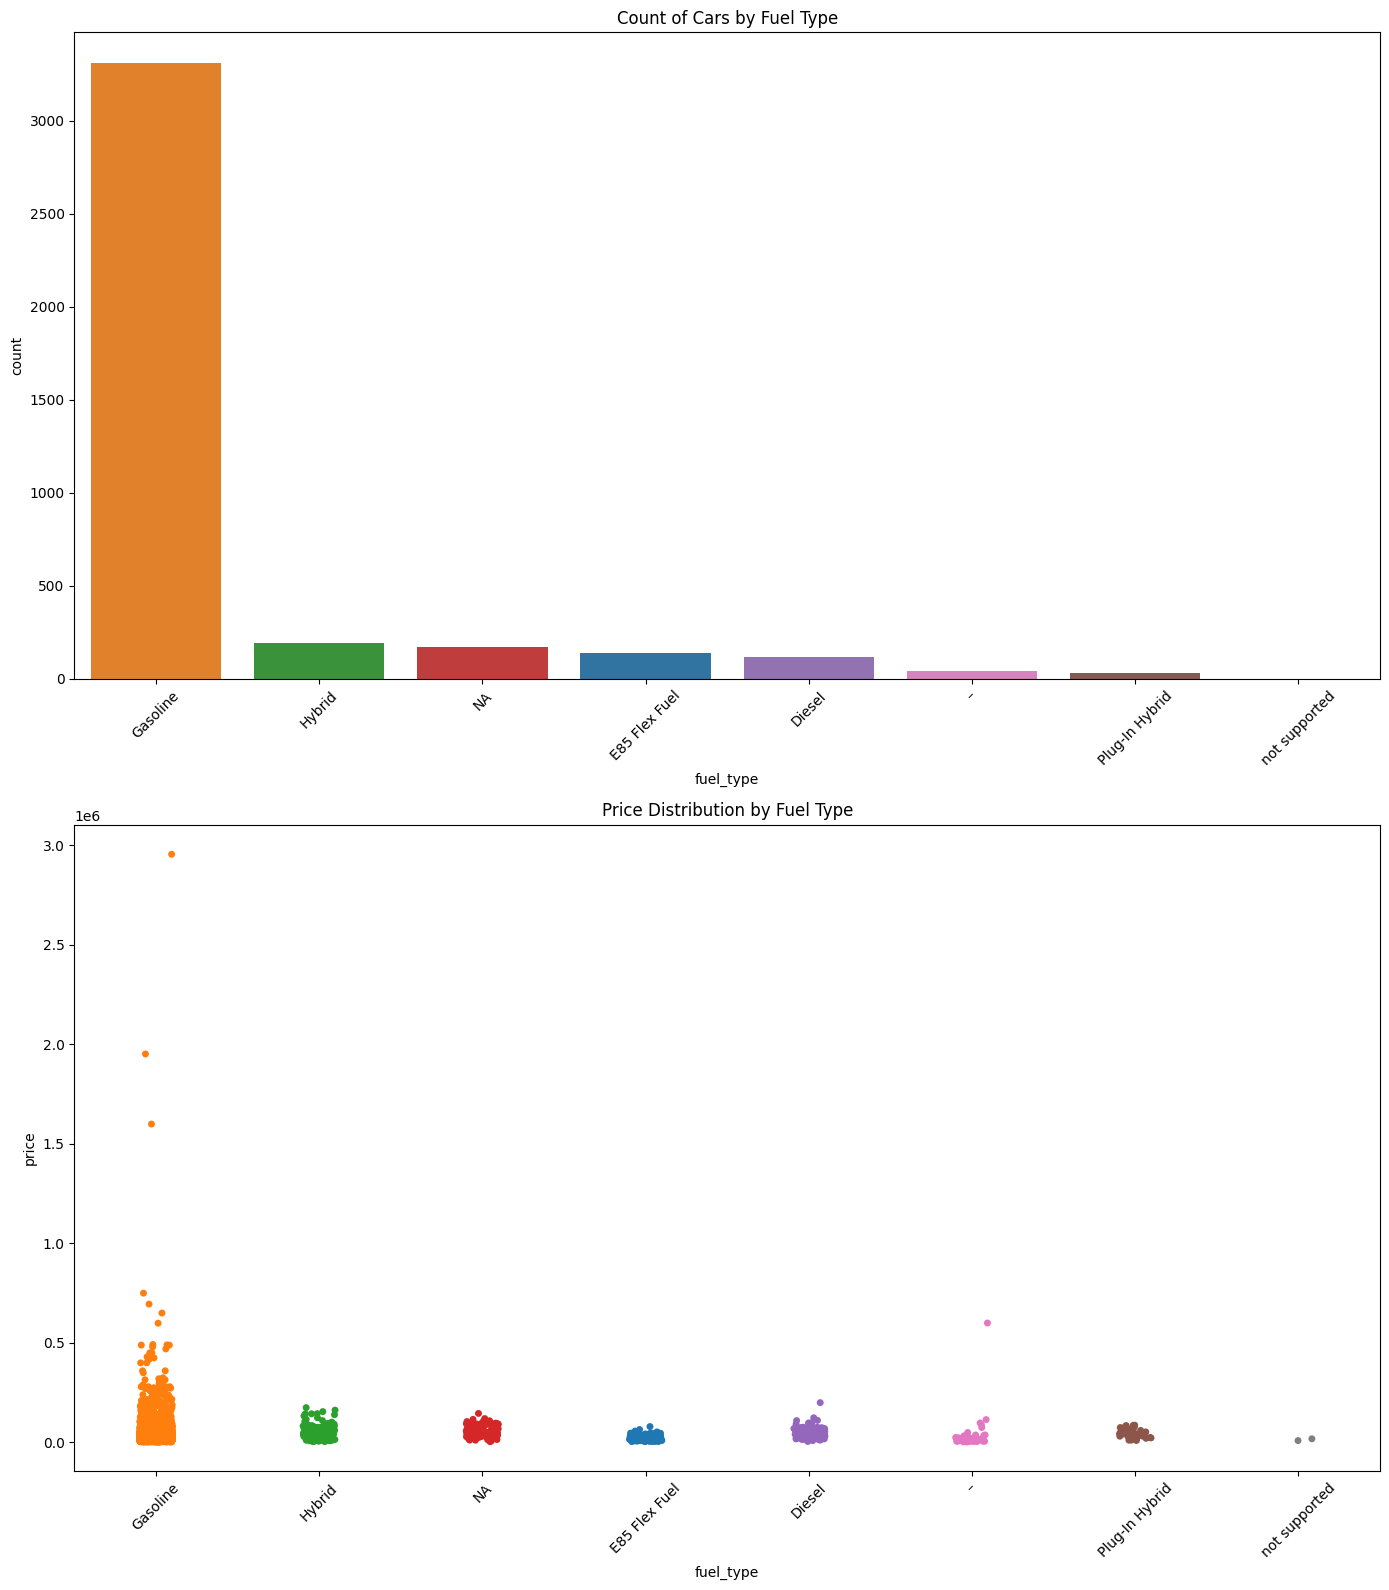

In [28]:
fuel_counts = fuel_data['fuel_type'].value_counts()

# Create a sorted list of fuel types based on counts
sorted_fuel_types = fuel_counts.index

plt.figure(figsize=(14, 16))

# Subplot for countplot
plt.subplot(211)
sns.countplot(x=fuel_data.fuel_type, hue=fuel_data.fuel_type, order=sorted_fuel_types)
plt.xticks(rotation=45)
plt.title('Count of Cars by Fuel Type')

# Subplot for stripplot
plt.subplot(212)
sns.stripplot(x=fuel_data.fuel_type, y=fuel_data.price, hue=fuel_data.fuel_type, order=sorted_fuel_types)
plt.xticks(rotation=45)
plt.title('Price Distribution by Fuel Type')
plt.legend([],[], frameon=False)  # Remove the legend for clarity

plt.tight_layout()
plt.show()


**Insights:**<br><br>
Gasoline vehicles dominate the market while hybrids command higher median prices. Diesel vehicles also have a notable median price of 45,450. High standard deviation in gasoline prices (85,051) indicates a wide range of models.<br><br> *Indeed, more fuel types could be extracted from engine or model names. This could be taken into consideration in section 2. Data Processing*

#### 1.6.4 Engine

By viewing the raw file, it is observed that the horsepower,engine displacement and related parameters of engine could be extracted from the name of engine as candidate predictors. Thus, instead of explore feature *engine* itself, we explore the related parameters of *engine*.

In [29]:
df['engine'].unique()

array(['300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability',
       '3.8L V6 24V GDI DOHC', '3.5 Liter DOHC', ...,
       '136.0HP 1.8L 4 Cylinder Engine Gasoline Fuel',
       '270.0HP 2.0L 4 Cylinder Engine Gasoline Fuel',
       '420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel'], dtype=object)

In [30]:
engine_data = df.copy()
# horsepower
engine_data['hp'] = engine_data.engine.apply(get_hp)
# engine displacement
engine_data['engine_'] = engine_data.engine.apply(get_engine)
# cylinder configuration
engine_data['cylinder'] = engine_data.engine.apply(get_cylinder)
# fuel injection type
engine_data['fi'] = engine_data.engine.apply(get_fi)
# turbocharger
engine_data['turbo'] = engine_data.engine.apply(get_turbo)

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/542782982.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.scatterplot(x=engine_data.hp.fillna(engine_data.hp.median()),y=engine_data.price,hue=engine_data.fuel_type)


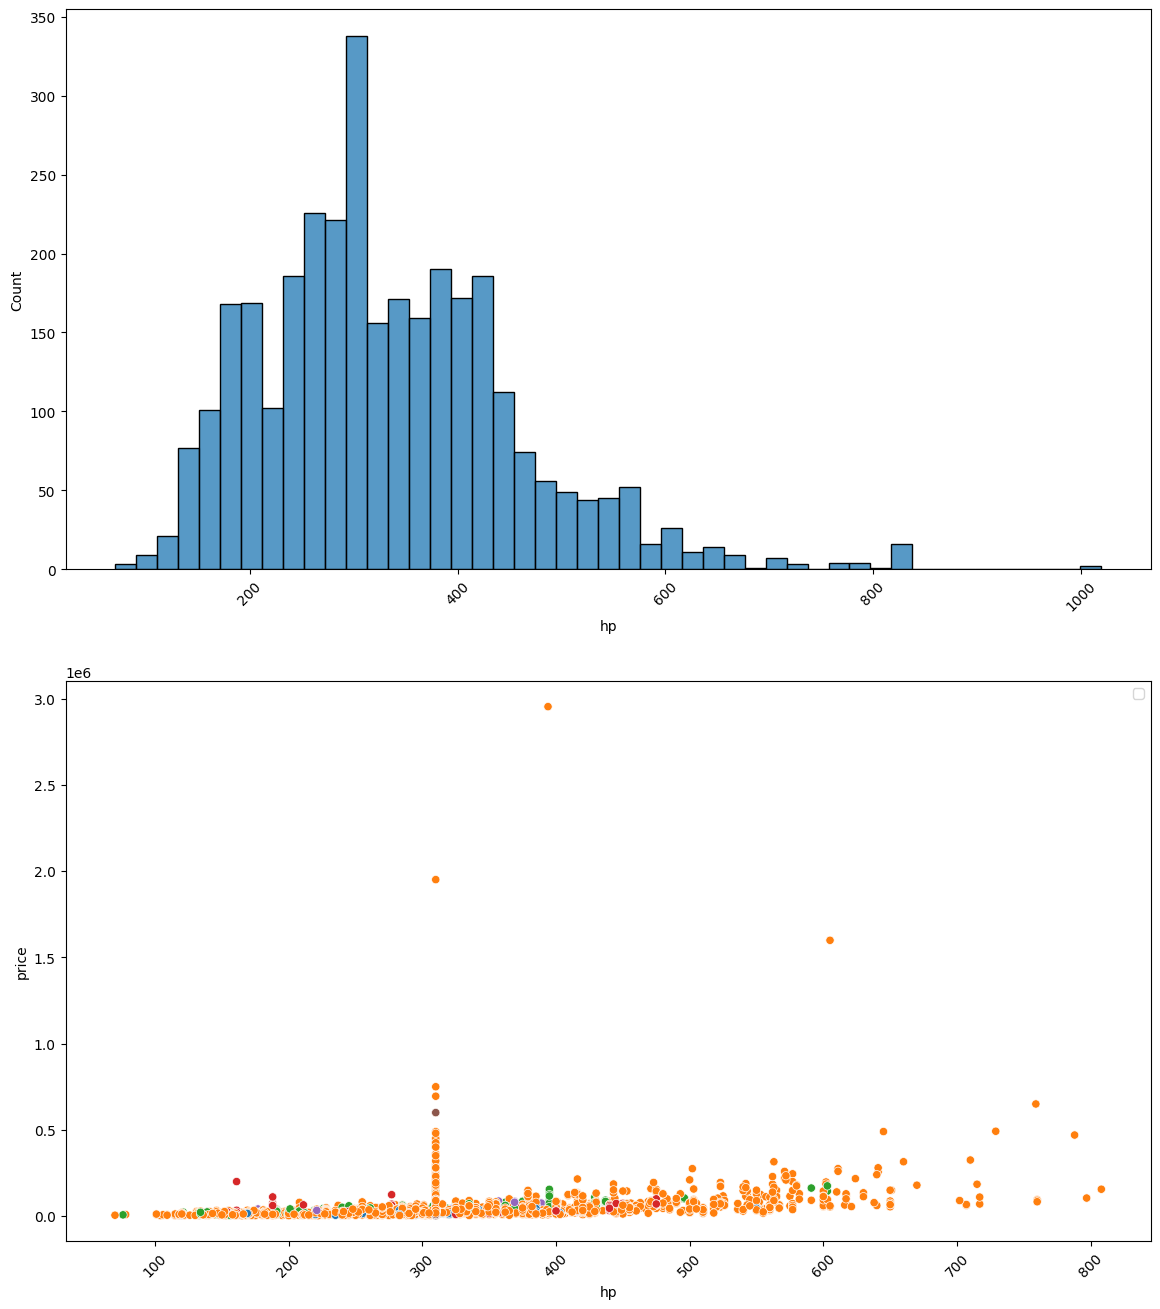

Correlation Cofficient: hp    0.601492
dtype: float64


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/542782982.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print('Correlation Cofficient:',engine_data[['hp']].fillna(engine_data.hp.median()).corrwith(engine_data.price,method='spearman'))


In [31]:
# Analysing HP
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.histplot(x=engine_data.hp.dropna())
plt.xticks(rotation=45)

plt.subplot(212)
sns.scatterplot(x=engine_data.hp.fillna(engine_data.hp.median()),y=engine_data.price,hue=engine_data.fuel_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

print('Correlation Cofficient:',engine_data[['hp']].fillna(engine_data.hp.median()).corrwith(engine_data.price,method='spearman'))


**Insights:**<br><br>
The correlation coefficient between horsepower (HP) and price suggests a positive correlation. This indicates that as horsepower increases, price tends to increase slightly, but the relationship is not significantly strong.


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/3132186633.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.scatterplot(x=engine_data.engine_.fillna(engine_data.engine_.median()),y=engine_data.price,hue=engine_data.fuel_type)


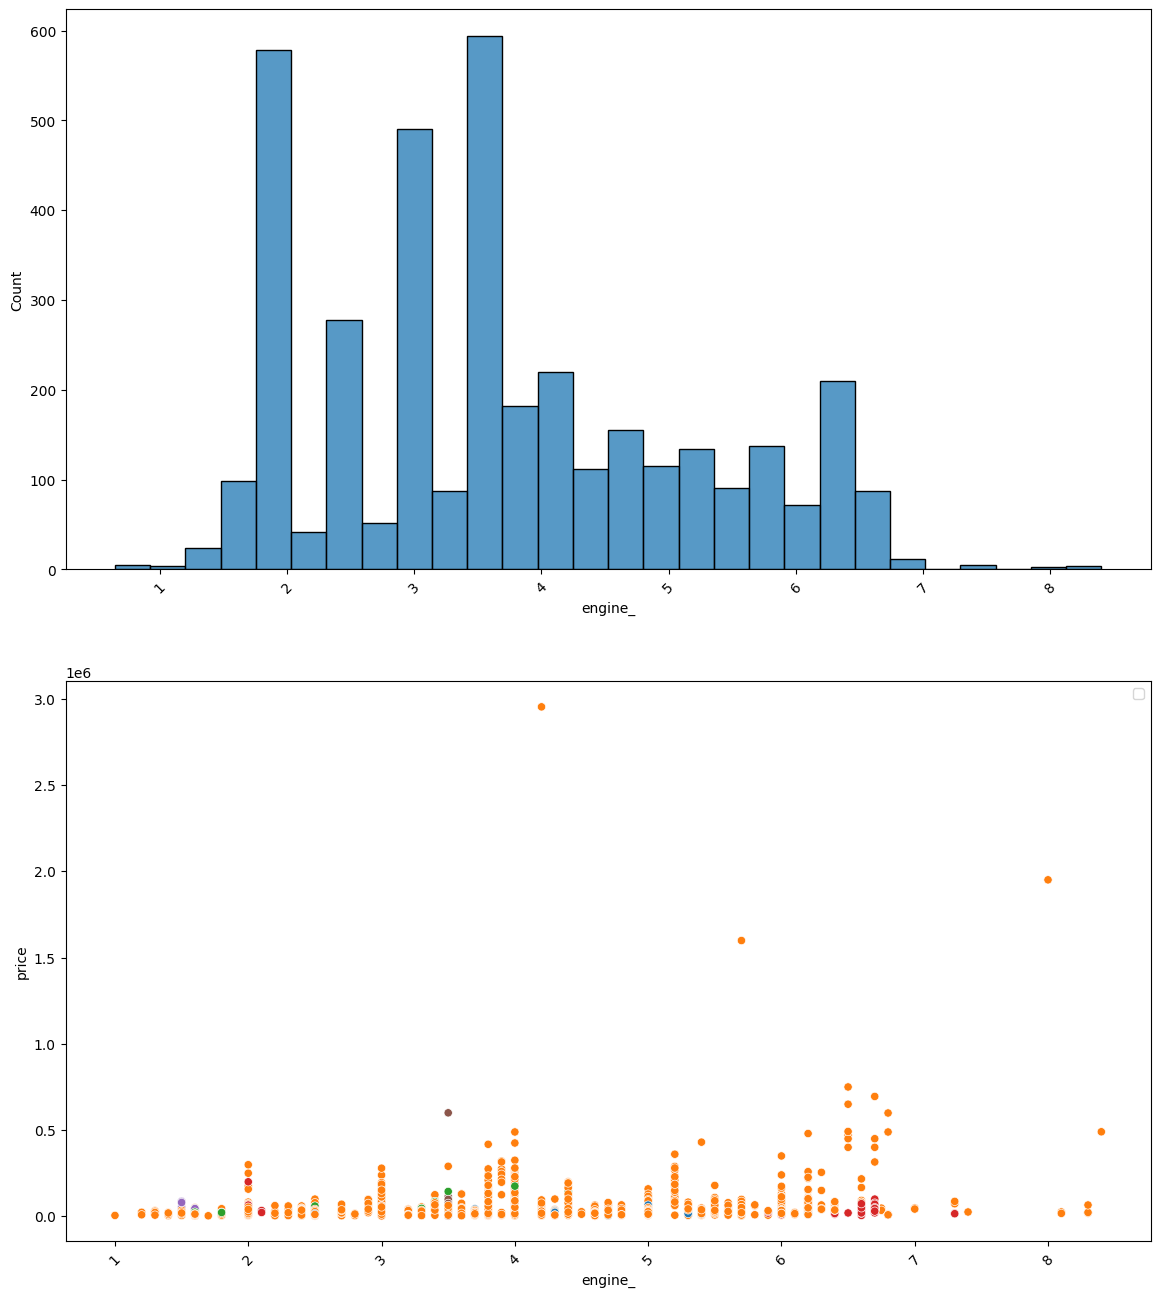

Correlation Cofficient: engine_    0.245694
dtype: float64


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/3132186633.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print('Correlation Cofficient:',engine_data[['engine_']].fillna(engine_data.engine_.median()).corrwith(engine_data.price,method='spearman'))


In [32]:
# Analysing Engine volumn
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.histplot(x=engine_data.engine_.dropna())
plt.xticks(rotation=45)

plt.subplot(212)
sns.scatterplot(x=engine_data.engine_.fillna(engine_data.engine_.median()),y=engine_data.price,hue=engine_data.fuel_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

print('Correlation Cofficient:',engine_data[['engine_']].fillna(engine_data.engine_.median()).corrwith(engine_data.price,method='spearman'))

**Insights:**<br><br>
The engine size (in liters) probably has little influence on vehicle pricing due to a relatively low correlation.



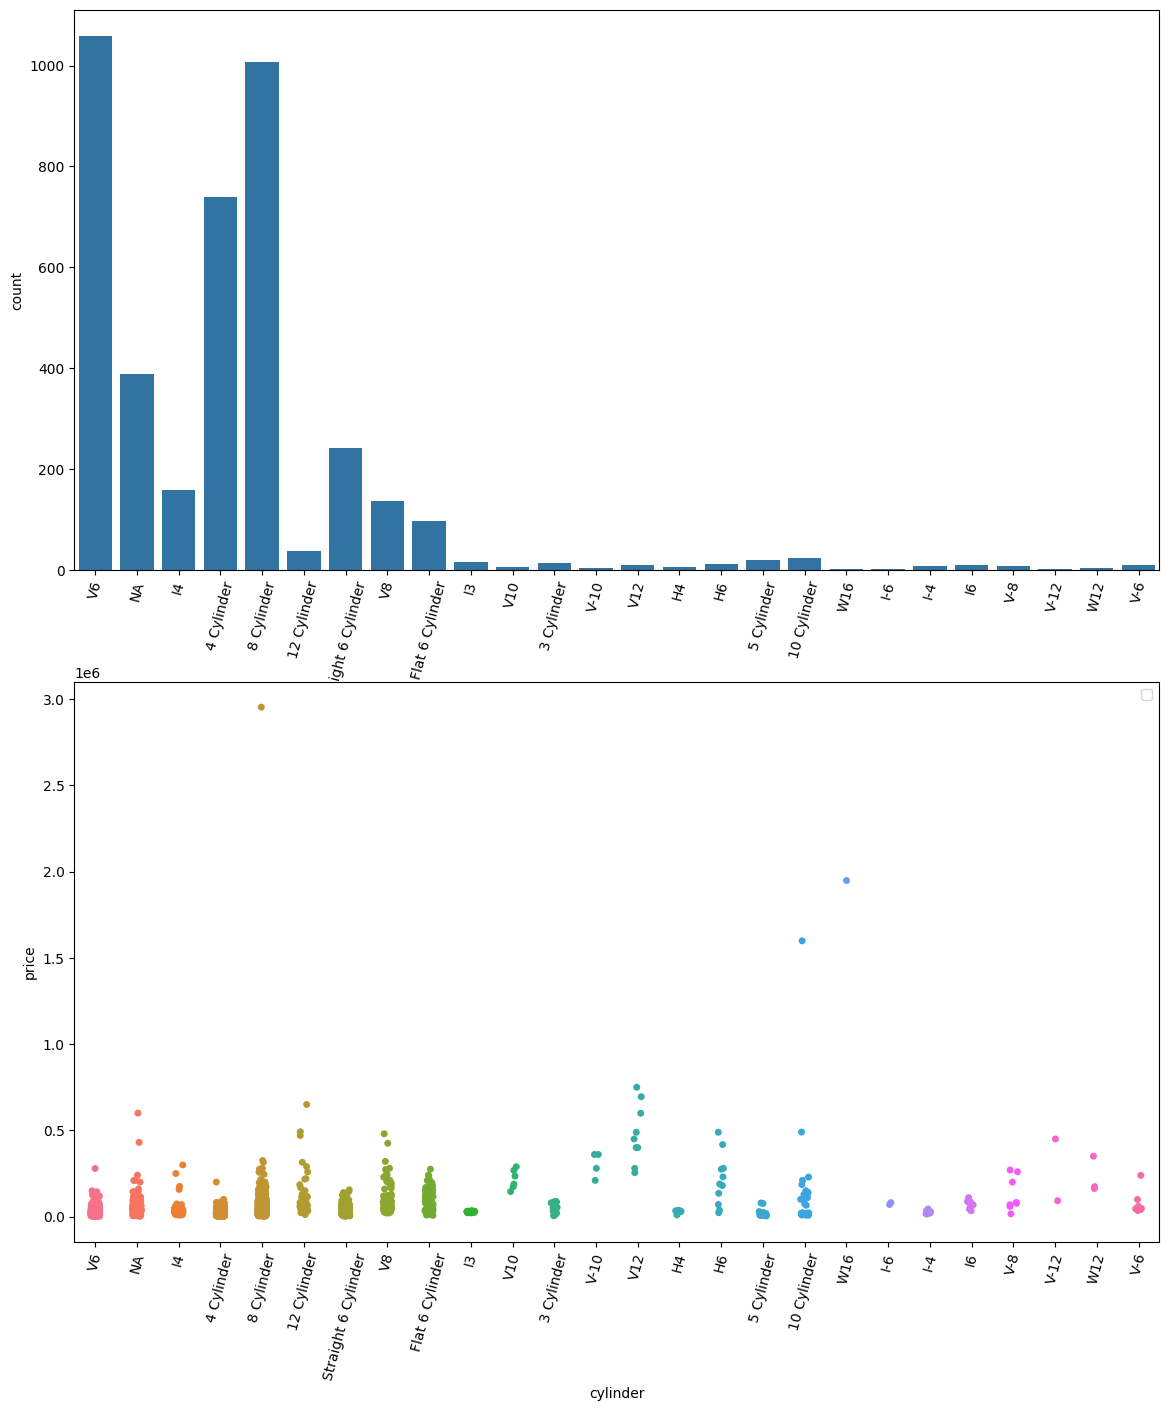

In [33]:
# Analysing cylinder
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=engine_data.cylinder)
plt.xticks(rotation=75)

plt.subplot(212)
sns.stripplot(x=engine_data.cylinder,y=engine_data.price,hue=engine_data.cylinder)
plt.xticks(rotation=75)
plt.legend([])
plt.show()

In [34]:
engine_data.groupby('cylinder')['price'].agg(['count','mean','median','std']).sort_values(by='count',ascending=False).reset_index()


,cylinder,count,mean,median,std
0,V6,1058,3.135620e+04,28795.0,21735.227078
1,8 Cylinder,1007,4.640131e+04,34500.0,99167.658060
2,4 Cylinder,739,2.247564e+04,19000.0,15651.347099
3,NA,388,5.319448e+04,44998.0,46621.589178
4,Straight 6 Cylinder,242,4.170019e+04,33499.5,30612.257420
5,I4,158,3.534835e+04,29342.5,33016.022862
6,V8,137,8.729378e+04,59590.0,75210.656756
7,Flat 6 Cylinder,96,8.632265e+04,71700.0,58594.566106
8,12 Cylinder,37,1.402592e+05,81330.0,142755.434199
9,10 Cylinder,23,1.665301e+05,100000.0,330753.535864


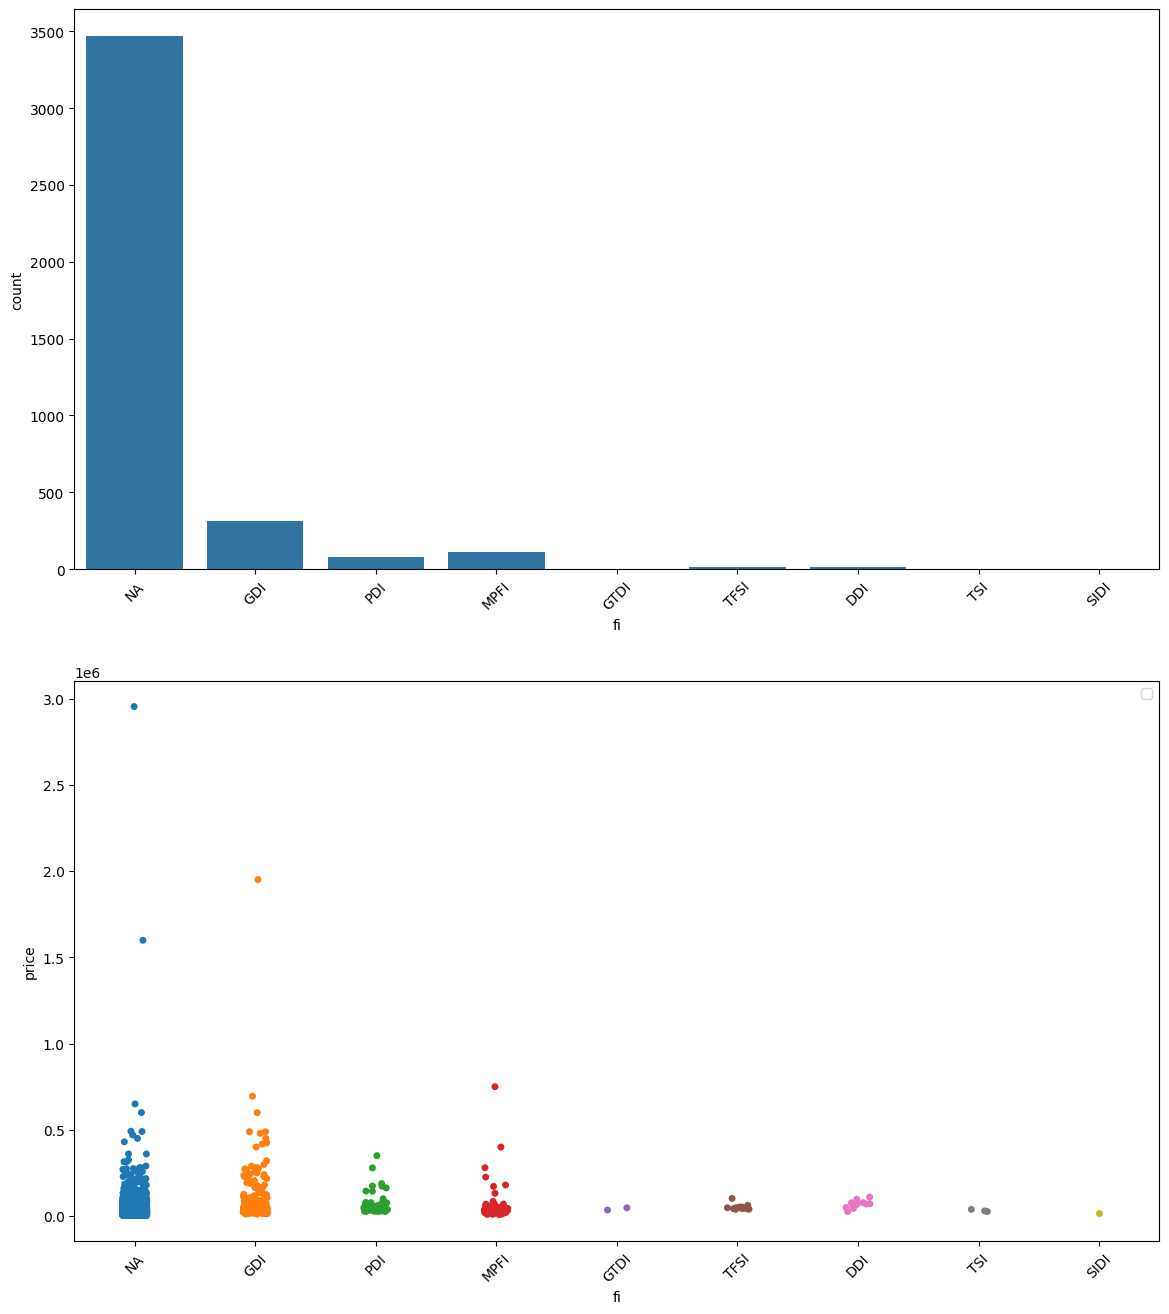

In [35]:
# Analysing fi
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=engine_data.fi)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=engine_data.fi,y=engine_data.price,hue=engine_data.fi)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

In [36]:
(engine_data.groupby('fi')['price']
 .agg(['count','mean','median','std'])
 .sort_values(by='count',ascending=False)
 .reset_index())

,fi,count,mean,median,std
0,NA,3471,40660.949294,29000.0,70022.144296
1,GDI,314,79063.121019,38939.0,142354.857532
2,MPFI,114,54563.798246,41164.0,82415.468230
3,PDI,78,60838.512821,43212.5,54825.318210
4,TFSI,15,49818.000000,44998.0,15629.377101
5,DDI,11,67602.727273,69998.0,23952.646384
6,TSI,3,31498.000000,29798.0,6518.435395
7,GTDI,2,41348.000000,41348.0,8980.256121
8,SIDI,1,19998.000000,19998.0,NaN


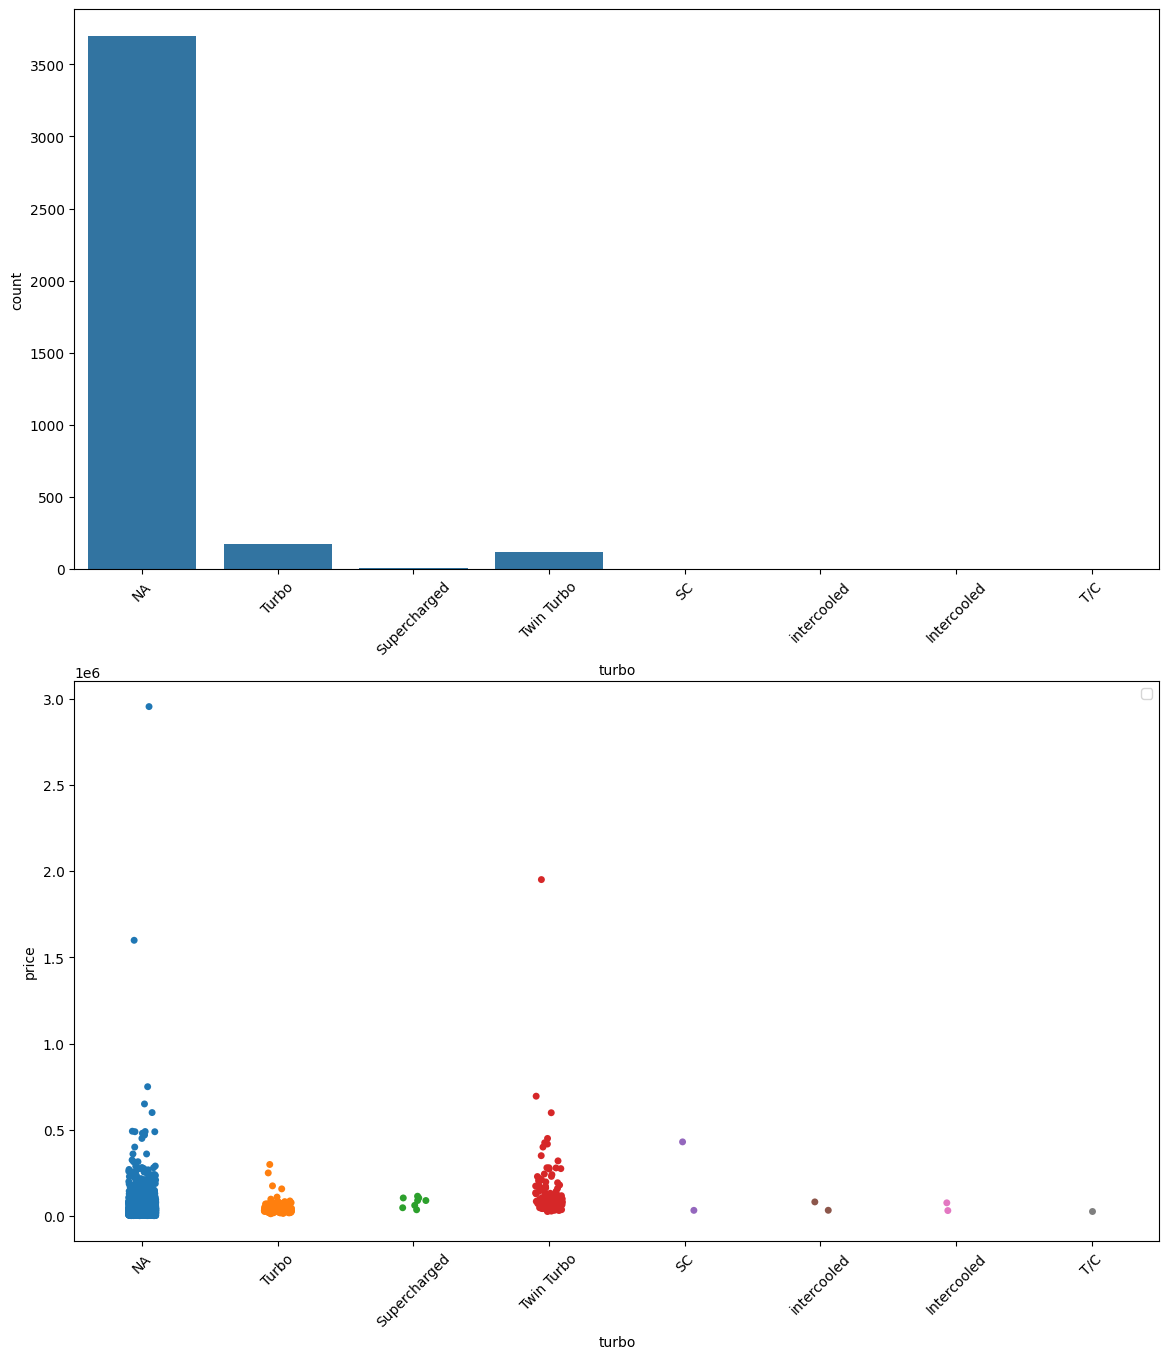

In [37]:
# Analysing turbo
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=engine_data.turbo)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=engine_data.turbo,y=engine_data.price,hue=engine_data.turbo)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


#### 1.6.5 Transmission

In [38]:
# Analysing transmission
transmission_data = df.copy()

transmission_data['transmission_type'] = transmission_data.transmission.apply(get_trans_type)
transmission_data['speed'] = transmission_data.transmission.apply(get_speed)

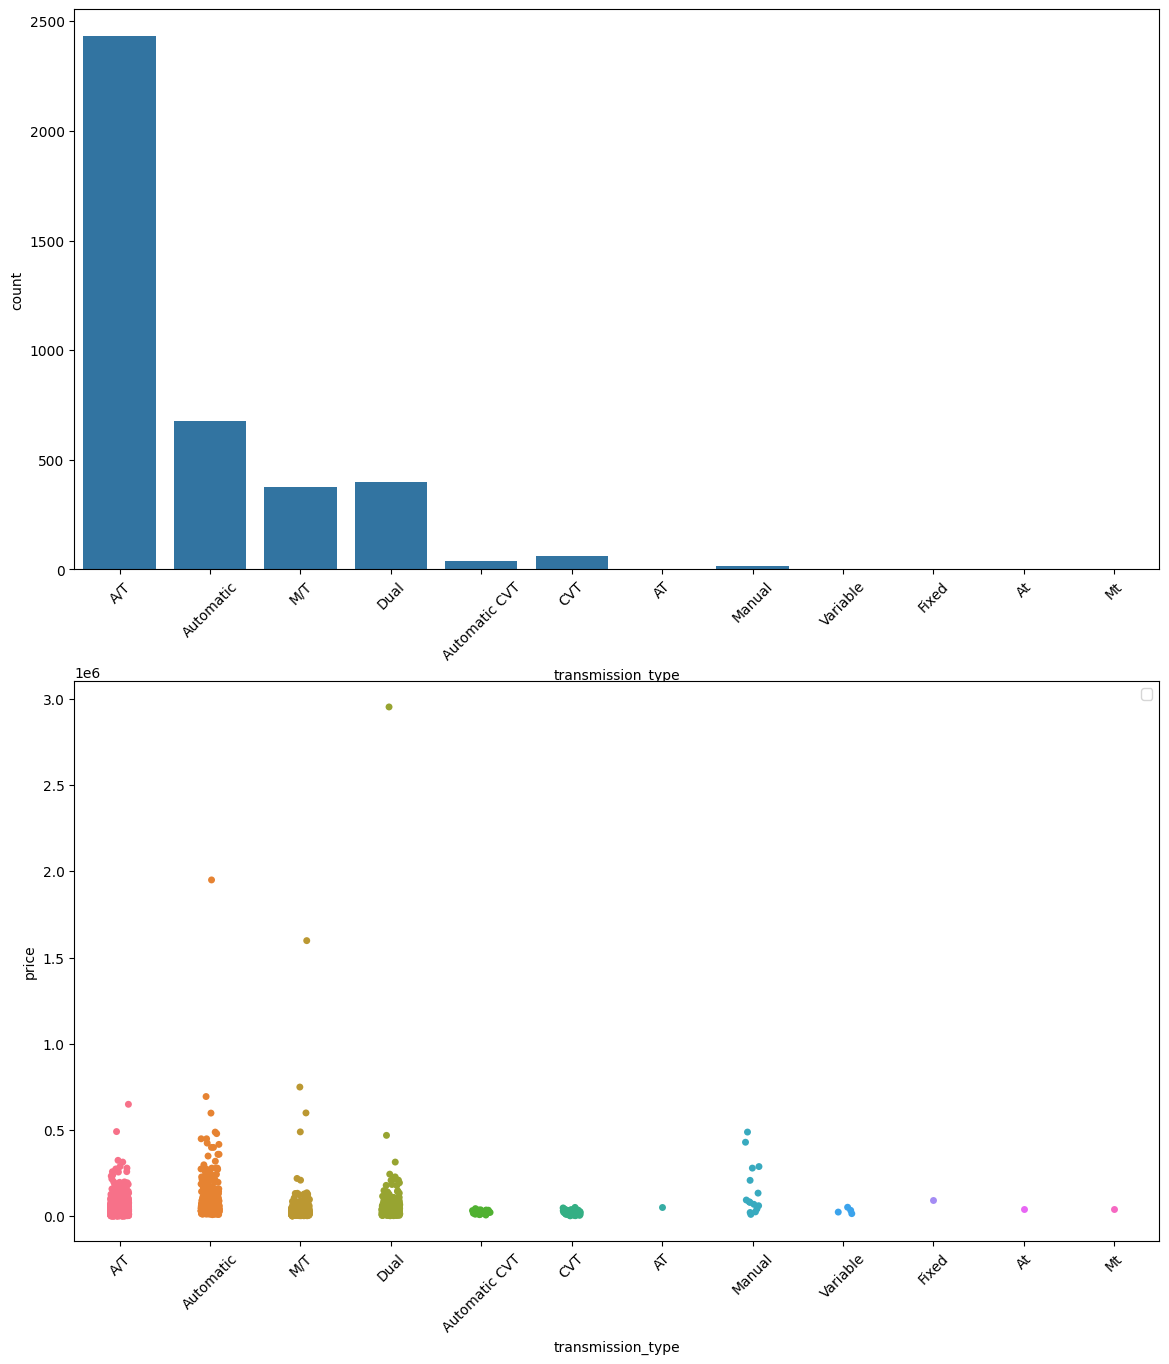

,transmission_type,count,mean,median,std
0,A/T,2433,36962.922318,28000.0,36852.969941
1,Automatic,678,68935.651917,43073.0,104099.442942
2,Dual,398,54710.615578,34000.0,152703.104130
3,M/T,377,40125.074271,23500.0,100255.992129
4,CVT,63,22086.317460,21499.0,10917.712312
5,Automatic CVT,37,25985.027027,25980.0,8123.722123
6,Manual,15,155148.666667,84645.0,151493.083896
7,Variable,4,32248.000000,29998.0,15861.378671
8,AT,1,51998.000000,51998.0,NaN
9,At,1,42998.000000,42998.0,NaN


In [39]:
# Analysing transmission type
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.countplot(x=transmission_data.transmission_type)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=transmission_data.transmission_type,y=transmission_data.price,hue=transmission_data.transmission_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()

(transmission_data.groupby('transmission_type')['price']
 .agg(['count','mean','median','std'])
 .sort_values(by='count',ascending=False)
.reset_index())


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/2148668308.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.stripplot(x=transmission_data.speed.fillna(transmission_data.speed.median()),y=transmission_data.price,hue=transmission_data.speed.fillna(transmission_data.speed.median()))
/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/2148668308.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.stripplot(x=transmission_data.speed.fillna(transmission_data.speed.median()),y=transmission_data.price,hue=transmission_dat

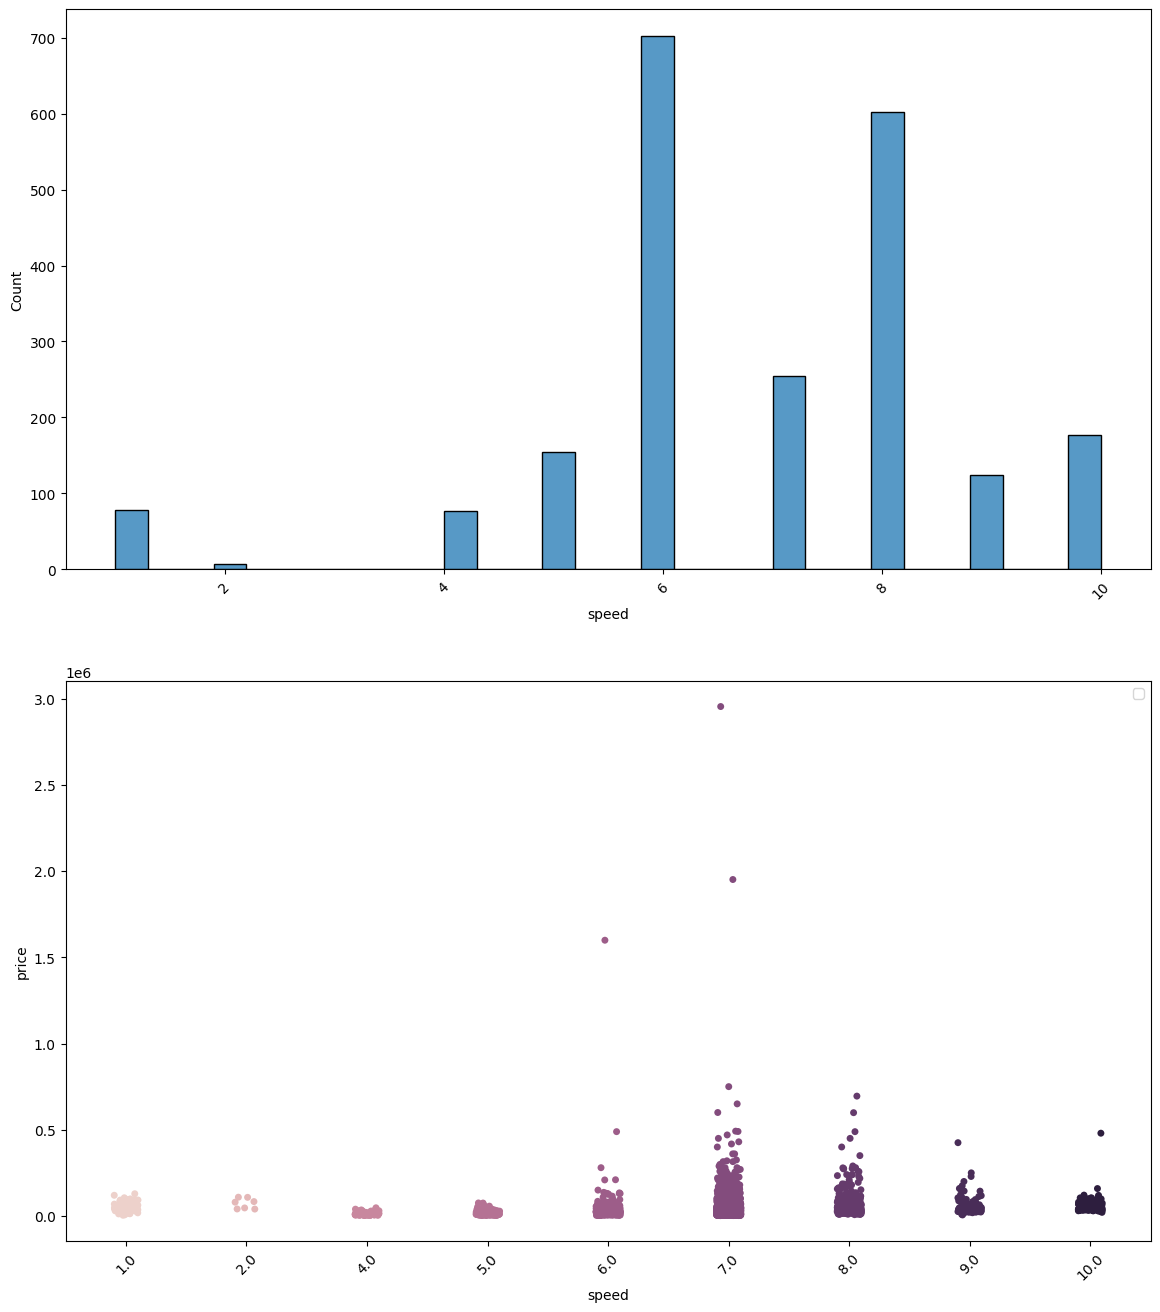

Correlation Cofficient: speed    0.331677
dtype: float64


/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/2148668308.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print('Correlation Cofficient:',transmission_data[['speed']].fillna(transmission_data.speed.median()).corrwith(transmission_data.price,method='spearman'))


In [40]:
# Analysing speed
plt.figure(figsize=(14,16))

plt.subplot(211)
sns.histplot(x=transmission_data.speed.dropna())
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=transmission_data.speed.fillna(transmission_data.speed.median()),y=transmission_data.price,hue=transmission_data.speed.fillna(transmission_data.speed.median()))
plt.xticks(rotation=45)
plt.legend([])
plt.show()

print('Correlation Cofficient:',transmission_data[['speed']].fillna(transmission_data.speed.median()).corrwith(transmission_data.price,method='spearman'))


#### 1.6.6 Color

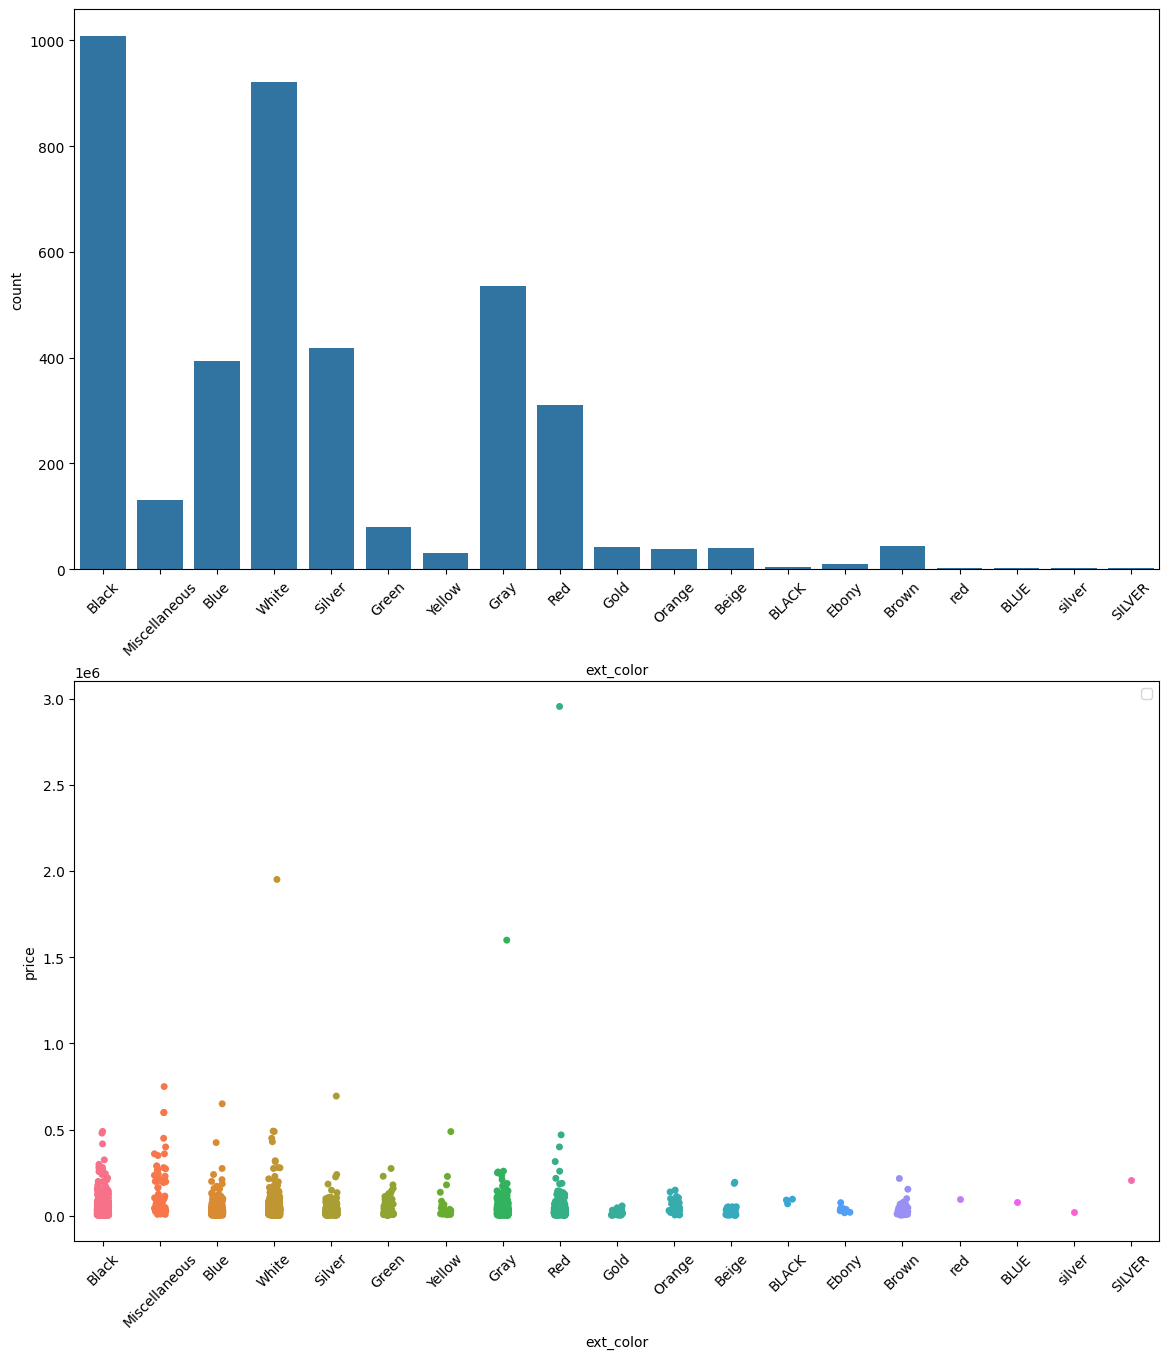

In [41]:
# Analysing External Color
color_data = df.copy()

color_data['ext_color'] = color_data['ext_col'].apply(get_color)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.ext_color)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.ext_color,y=color_data.price,hue=color_data.ext_color)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


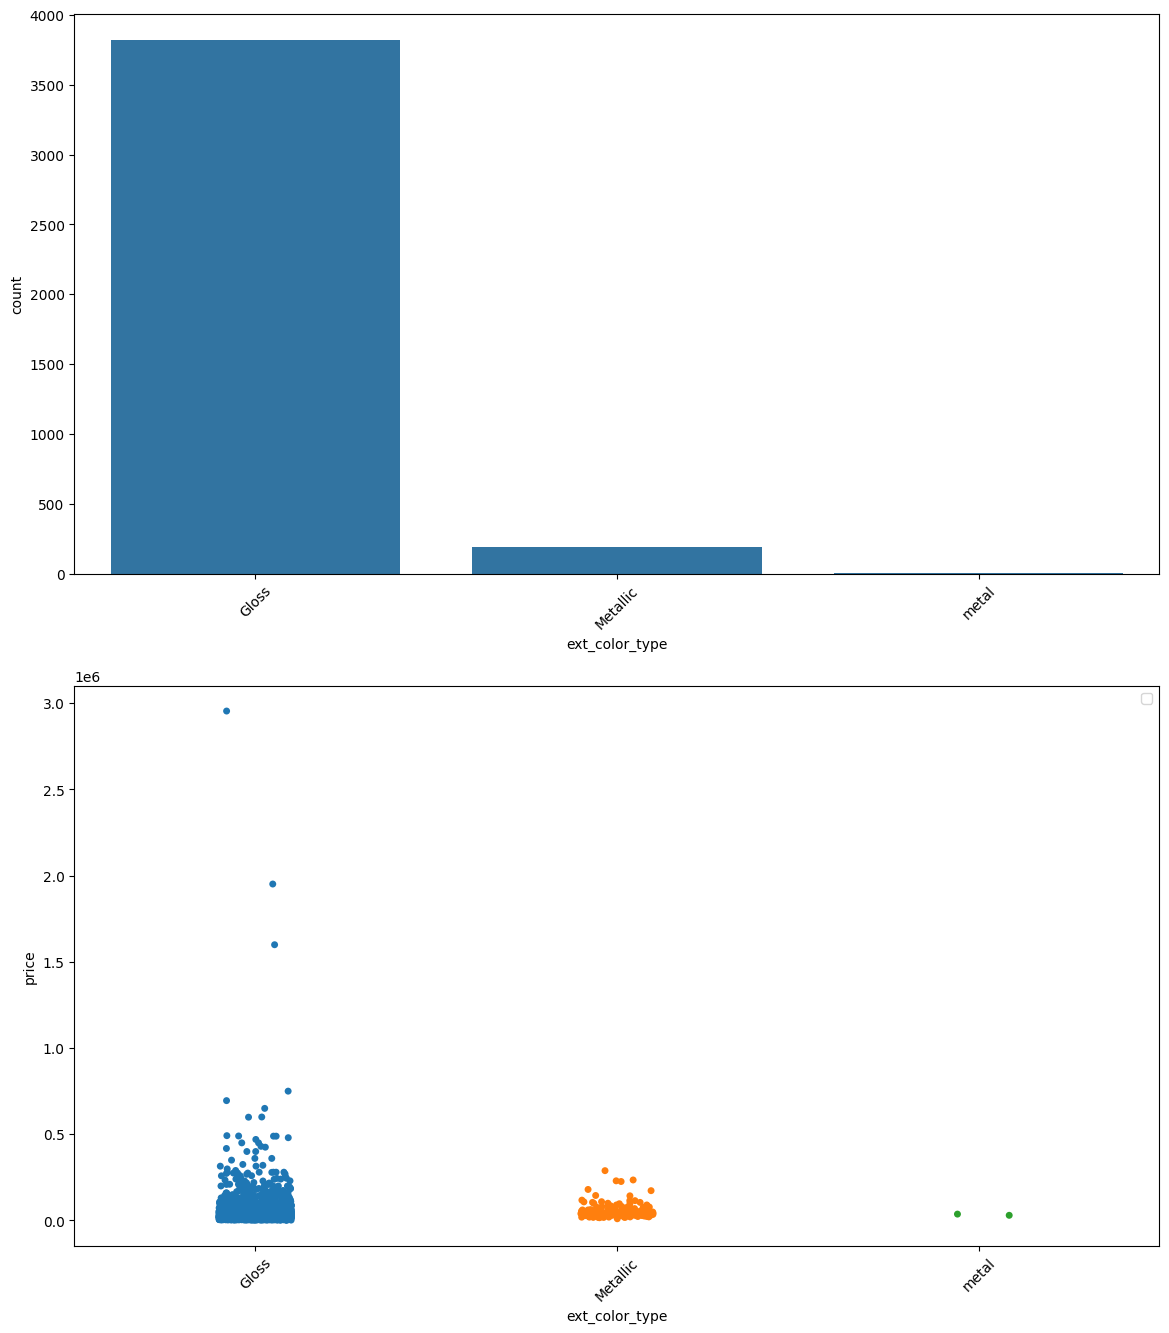

In [42]:
color_data['ext_color_type'] = color_data['ext_col'].apply(get_color_type)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.ext_color_type)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.ext_color_type,y=color_data.price,hue=color_data.ext_color_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


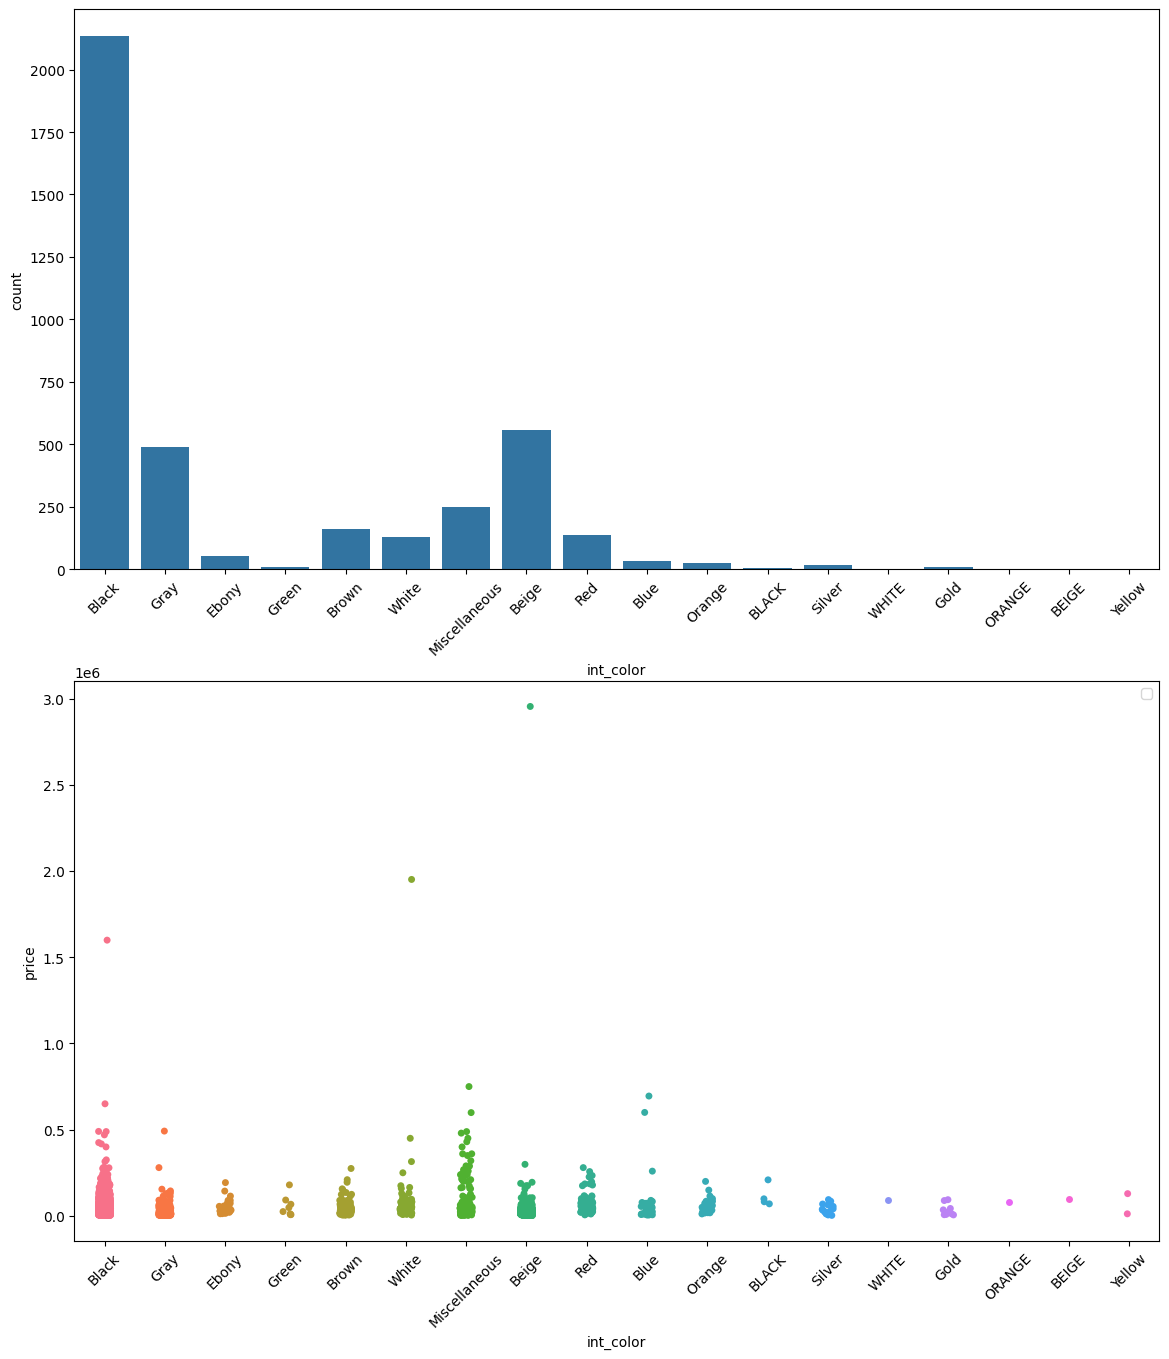

In [43]:
# Analysing Internal color
color_data['int_color'] = color_data['int_col'].apply(get_color)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.int_color)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.int_color,y=color_data.price,hue=color_data.int_color)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


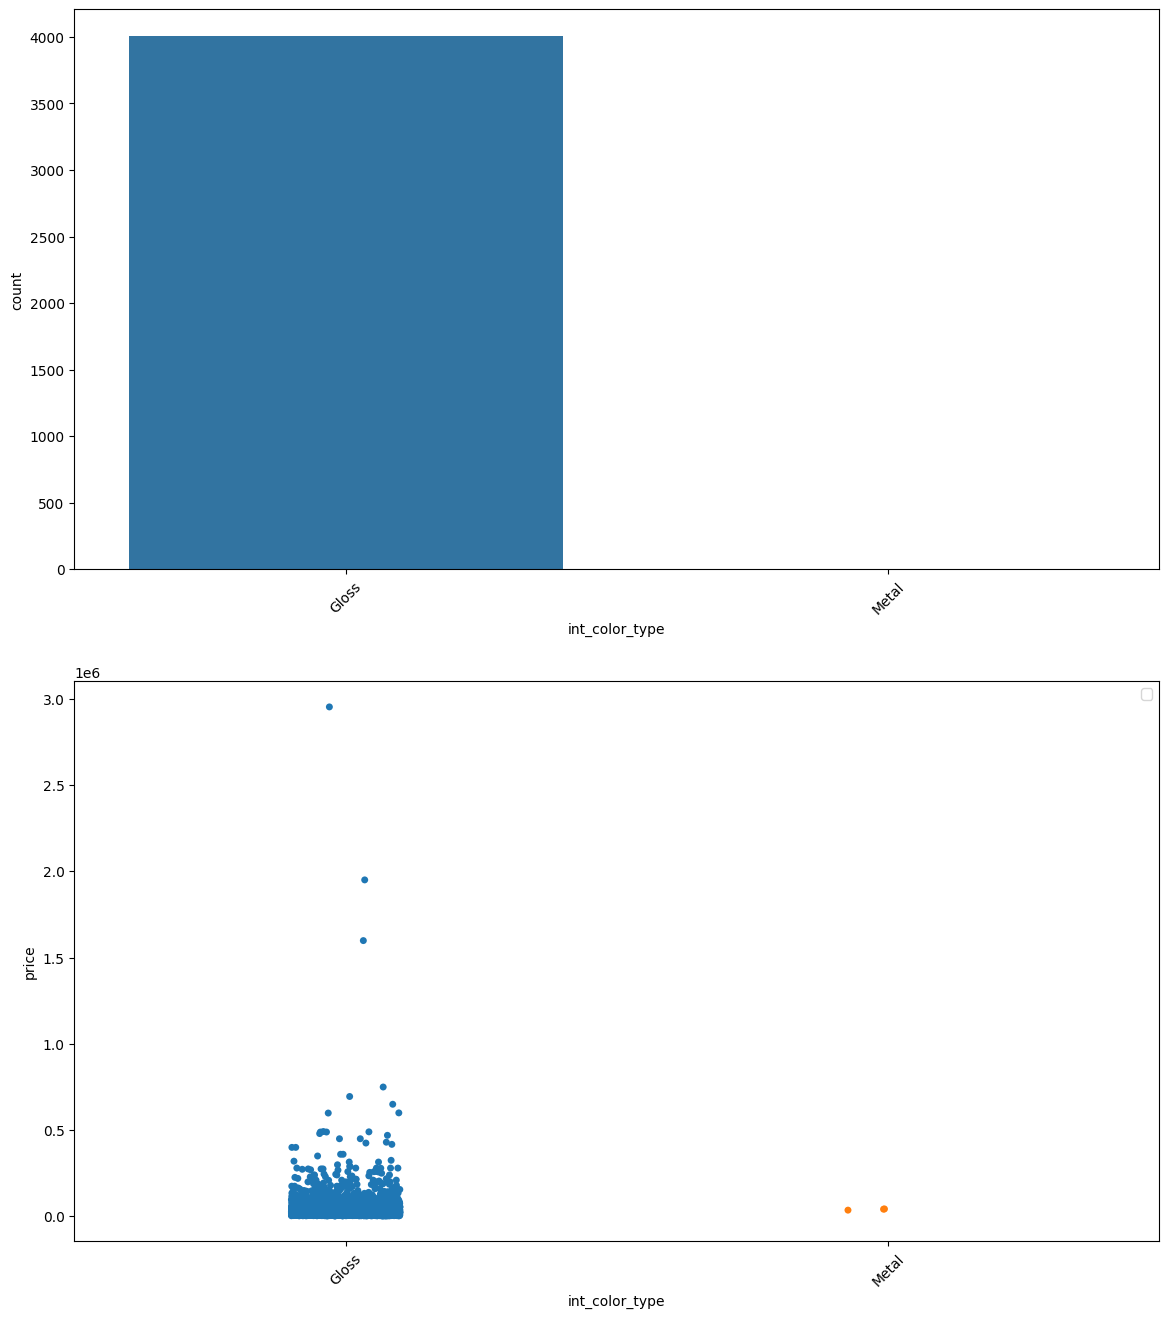

In [44]:
color_data['int_color_type'] = color_data['int_col'].apply(get_color_type)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=color_data.int_color_type)
plt.xticks(rotation=45)

plt.subplot(212)
sns.stripplot(x=color_data.int_color_type,y=color_data.price,hue=color_data.int_color_type)
plt.xticks(rotation=45)
plt.legend([])
plt.show()


#### 1.6.7 Accident

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/2273496196.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  accident_data['accident'].fillna('None reported',inplace=True)


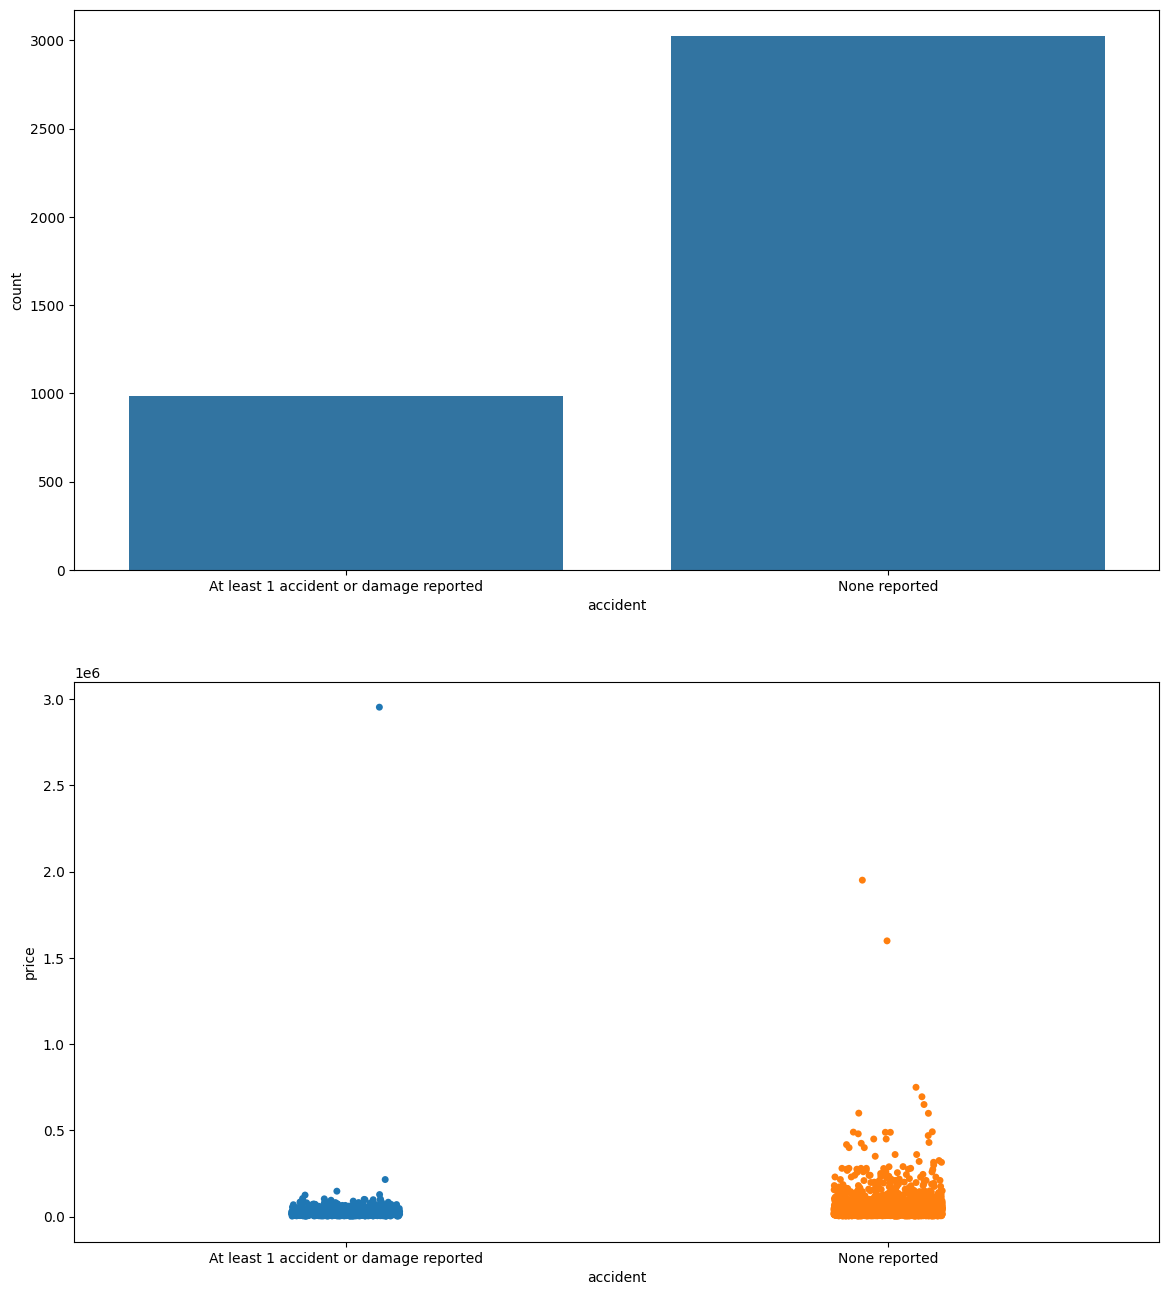

,accident,count,mean,median,std
0,At least 1 accident or damage reported,986,28831.500000,20900.0,95401.765975
1,None reported,3023,49681.072114,35690.0,71716.321914


In [45]:
# Analysing accident
accident_data  = df.copy()

accident_data['accident'].fillna('None reported',inplace=True)
plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=accident_data.accident)

plt.subplot(212)
sns.stripplot(x=accident_data.accident,y=accident_data.price,hue=accident_data.accident)
plt.show()

accident_data.groupby('accident')['price'].agg(['count','mean','median','std']).reset_index()


#### 1.6.8 Clean Title

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/1627584503.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  title_data['clean_title'].fillna('No',inplace=True)


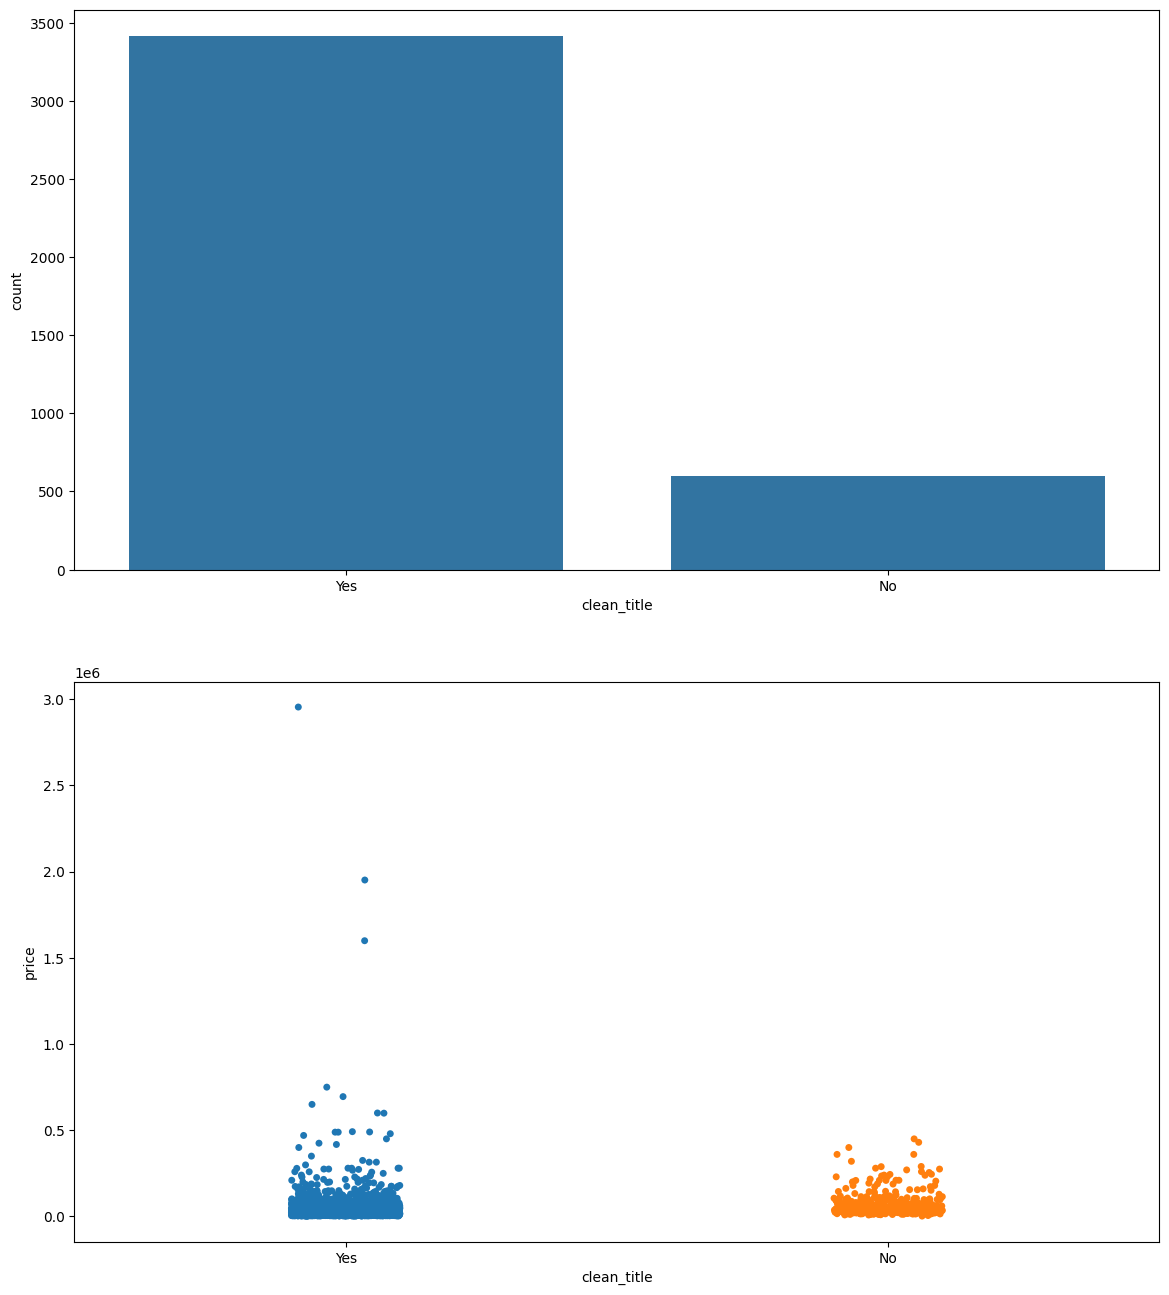

,clean_title,count,mean,median,std
0,No,596,60695.077181,42996.5,57982.778955
1,Yes,3413,41734.390272,29000.0,81472.770029


In [46]:
# Analysing clean title
title_data = df.copy()
title_data['clean_title'].fillna('No',inplace=True)

plt.figure(figsize=(14,16))
plt.subplot(211)
sns.countplot(x=title_data.clean_title)

plt.subplot(212)
sns.stripplot(x=title_data.clean_title,y=title_data.price,hue=title_data.clean_title)
plt.show()

title_data.groupby('clean_title')['price'].agg(['count','mean','median','std']).reset_index()


## 2. Data Preprocessing

### 2.1 Handling Null Values

The rationale of handling null values can be found in [1.3 analysis of null value](#13-analysis-of-null-values)

In [47]:
def fill_missing(data):
    data = data.copy()
    
    # Filling missing fuel type from engine description and model name
    data['fuel_type'].fillna('NA',inplace=True)
    data['fuel_type2'] = data['engine'].apply(get_fuel_type)
    data['fuel_type3'] = data['model'].apply(get_fuel_type)

    data['fuel_type'] = np.where(
        data.fuel_type.isin(['NA','–','not supported']),   # Condition
        np.where(data.fuel_type2 == 'NA',data.fuel_type3,data.fuel_type2),  # True Value
        data.fuel_type   # False value
    )

    data['accident'] = data['accident'].fillna('None reported')
    data['clean_title'] = data['clean_title'].fillna('No')
    
    return data

# combined_data = get_imputed_data(combined_data)
# original = get_imputed_data(original)
df = fill_missing(df)

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/1714334401.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['fuel_type'].fillna('NA',inplace=True)


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   float64
 4   fuel_type     4009 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      4009 non-null   object 
 10  clean_title   4009 non-null   object 
 11  price         4009 non-null   float64
 12  fuel_type2    4009 non-null   object 
 13  fuel_type3    4009 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 438.6+ KB


### 2.2 Data Cleaning

In [49]:
def cleaning_data(data):
    data = data.copy()
        
    # Extracting details from engine feature
    data['hp'] = data.engine.apply(get_hp)
    data['engine_'] = data.engine.apply(get_engine)
    data['cylinder'] = data.engine.apply(get_cylinder)
    data['fi'] = data.engine.apply(get_fi)
    data['turbo'] = data.engine.apply(get_turbo)

    # Extracting transmission details from transmission feature
    data['transmission_type'] = data.transmission.apply(get_trans_type)
    data['speed'] = data.transmission.apply(get_speed)

    # Extracting color details from color related features
    data['ext_color'] = data['ext_col'].apply(get_color)
    data['ext_color_type'] = data['ext_col'].apply(get_color_type)
    data['int_color'] = data['int_col'].apply(get_color)
    data['int_color_type'] = data['int_col'].apply(get_color_type)

    # Cleaning fuel type feature
    data['fuel_type'].replace(['ev','eV','Battery','Ev','Electric','motor'],'EV',inplace=True)
    data['fuel_type'].replace(['E85 Flex Fuel'],'Flex',inplace=True)
    data['fuel_type'].replace(['Plug-In Hybrid'],'Hybrid',inplace=True)

    # Cleaning cylinder feature
    data['cylinder'].replace(['Flat 6 Cylinder','Straight 6 Cylinder'],'H6',inplace=True)
    data['cylinder'].replace(['V-8'],'V8',inplace=True)
    data['cylinder'].replace(['I-4'],'I4',inplace=True)

    # Cleaning turbo feature
    data['turbo'].replace(['Supercharged'],'SC',inplace=True)
    data['turbo'].replace(['T/C'],'Turbo',inplace=True)

    # Cleaning transmission type feature
    data['transmission_type'].replace(['A/T','At','AT'],'Automatic',inplace=True)
    data['transmission_type'].replace(['M/T','Mt','MT'],'Manual',inplace=True)
    data['transmission_type'].replace(['CVT','Automatic CVT'],'Variable',inplace=True)

    # Cleaning External/Internal color
    data['int_color']  = data['int_color'].str.lower()
    data['ext_color']  = data['ext_color'].str.lower()

    # Cleaning External/Internal color type
    data['ext_color_type'].replace(['metal'],'Metallic',inplace=True)
    data['int_color_type'].replace(['Metal'],'Metallic',inplace=True)

    # Imputing median value for NA values in hp,engine_(volume of engine) and speed(TRANSMISSION) feature
    hp_median = data.groupby('cylinder')['hp'].transform(lambda x:x.median()).fillna(data.hp.median())
    data['hp'] = np.where(data.hp.isna(), hp_median, data.hp)

    engine_median = data.groupby('cylinder')['engine_'].transform(lambda x: x.median()).fillna(data.engine_.median())
    data['engine_'] = np.where(data.engine_.isna(), engine_median, data.engine_)

    speed_median = data.groupby('transmission_type')['speed'].transform(lambda x: x.median()).fillna(data.speed.median())
    data['speed'] = np.where(data.speed.isna(), speed_median, data.speed)
    
    return data

df = cleaning_data(df)

/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/3531768301.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['fuel_type'].replace(['ev','eV','Battery','Ev','Electric','motor'],'EV',inplace=True)
/var/folders/_5/ztyxm4j95854xqs2k_x83m1c0000gn/T/ipykernel_82249/3531768301.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              4009 non-null   object 
 1   model              4009 non-null   object 
 2   model_year         4009 non-null   int64  
 3   milage             4009 non-null   float64
 4   fuel_type          4009 non-null   object 
 5   engine             4009 non-null   object 
 6   transmission       4009 non-null   object 
 7   ext_col            4009 non-null   object 
 8   int_col            4009 non-null   object 
 9   accident           4009 non-null   object 
 10  clean_title        4009 non-null   object 
 11  price              4009 non-null   float64
 12  fuel_type2         4009 non-null   object 
 13  fuel_type3         4009 non-null   object 
 14  hp                 4009 non-null   object 
 15  engine_            4009 non-null   object 
 16  cylinder           4009 

### 2.3 Feature Engineering

In [51]:
def add_features(data):
    data = data.copy()
    current_year = datetime.datetime.now().year
    # Creating car age 
    data['car_age'] = current_year - data.model_year + 1

    # Creating mileage per year
    data['mileage_per_year'] = data['milage'] / data['car_age']

    # # Creating mileage with age
    # data['mileage_with_age'] = data.groupby('car_age')['milage'].transform('mean').fillna(data.milage.mean())

    # # Creating mileage per year with age
    # data['mileage_per_year_with_age'] = data.groupby('car_age')['mileage_per_year'].transform('mean').fillna(data.mileage_per_year.mean())

    # Creating power to weight ratio
    data['power_to_weight_ratio'] = (data['hp'] / data['engine_']).astype(float)

    # Adding separate feature for luxury and supercar brands
    luxury_and_supercar_brands = [ "Mercedes-Benz", "BMW", "Audi", "Lexus", "Acura", "Jaguar", 
                                  "INFINITI", "Cadillac", "Lincoln", "Volvo", "Tesla",
                                  "Maserati", "Bentley", "Genesis", "Ferrari", "Rolls-Royce",
                                  "Aston", "McLaren", "Bugatti", "Lamborghini", "Porsche"]
    data['is_luxury_super']  = data.brand.isin(luxury_and_supercar_brands).astype(int)
    
    return data
df = add_features(df)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand                  4009 non-null   object 
 1   model                  4009 non-null   object 
 2   model_year             4009 non-null   int64  
 3   milage                 4009 non-null   float64
 4   fuel_type              4009 non-null   object 
 5   engine                 4009 non-null   object 
 6   transmission           4009 non-null   object 
 7   ext_col                4009 non-null   object 
 8   int_col                4009 non-null   object 
 9   accident               4009 non-null   object 
 10  clean_title            4009 non-null   object 
 11  price                  4009 non-null   float64
 12  fuel_type2             4009 non-null   object 
 13  fuel_type3             4009 non-null   object 
 14  hp                     4009 non-null   object 
 15  engi

### 2.4 Data Type Conversion

In [53]:
def set_dtypes(data):
    data = data.copy()

    data['hp'] = data['hp'].astype(float)
    data['engine_'] = data['engine_'].astype(float)
    data['speed'] = data['speed'].astype(float)
    
    return data
df=set_dtypes(df)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand                  4009 non-null   object 
 1   model                  4009 non-null   object 
 2   model_year             4009 non-null   int64  
 3   milage                 4009 non-null   float64
 4   fuel_type              4009 non-null   object 
 5   engine                 4009 non-null   object 
 6   transmission           4009 non-null   object 
 7   ext_col                4009 non-null   object 
 8   int_col                4009 non-null   object 
 9   accident               4009 non-null   object 
 10  clean_title            4009 non-null   object 
 11  price                  4009 non-null   float64
 12  fuel_type2             4009 non-null   object 
 13  fuel_type3             4009 non-null   object 
 14  hp                     4009 non-null   float64
 15  engi

### 2.5 Data Encoding for Categorical Variables

In [55]:
def encode(data):
    data = data.copy()
    

    # label encoding should be avoided!!!!!!!!!!!!!!?

    l_enc = LabelEncoder()
    # data['brand'] = l_enc.fit_transform(data['brand'])
    data['model'] = l_enc.fit_transform(data['model'])
    data['cylinder'] = l_enc.fit_transform(data['cylinder'])
    # data['ext_color'] = l_enc.fit_transform(data['ext_color'])
    # data['int_color'] = l_enc.fit_transform(data['int_color'])

    # OneHot encoding on features
    # cat_feat = ['fuel_type','accident','clean_title','fi','turbo','transmission_type','ext_color_type','int_color_type']
    # data = pd.get_dummies(data,columns=cat_feat,dtype=int,drop_first=True)
    
    return data

df = encode(df)

In [56]:
print(df['fuel_type'].value_counts())

fuel_type
Gasoline    3309
Hybrid       228
EV           172
Flex         139
Diesel       116
NA            42
Motor          3
Name: count, dtype: int64


In [57]:
df['brand'].value_counts()

brand
Ford             386
BMW              375
Mercedes-Benz    315
Chevrolet        292
Porsche          201
Audi             200
Toyota           199
Lexus            163
Jeep             143
Land             130
Nissan           116
Cadillac         107
GMC               91
RAM               91
Dodge             90
Tesla             87
Kia               76
Hyundai           72
Mazda             64
Acura             64
Subaru            64
Honda             63
Volkswagen        59
INFINITI          59
Lincoln           52
Jaguar            47
Volvo             38
Maserati          34
Bentley           33
MINI              33
Buick             30
Chrysler          28
Lamborghini       26
Mitsubishi        20
Genesis           20
Alfa              19
Rivian            17
Hummer            16
Pontiac           15
Ferrari           12
Rolls-Royce       11
Aston              9
McLaren            6
Scion              6
FIAT               5
Saturn             5
Lotus              4
Lucid  

In [58]:
# USA, Japan, Germany, Italy, UK, South Korea, Sweden
country_mapping = {
    'Ford': 'USA', 'Chevrolet': 'USA', 'Cadillac': 'USA', 'GMC': 'USA', 'RAM': 'USA', 
    'Dodge': 'USA', 'Tesla': 'USA', 'Jeep': 'USA', 'Lincoln': 'USA', 'Buick': 'USA',
    'Chrysler': 'USA', 'Rivian': 'USA', 'Hummer': 'USA', 'Pontiac': 'USA', 'Lucid': 'USA',
    'Mercury': 'USA', 'Karma': 'USA', 'Polestar': 'USA', 'Saturn': 'USA', 'Plymouth': 'USA',

    'BMW': 'Germany', 'Mercedes-Benz': 'Germany', 'Audi': 'Germany', 'Porsche': 'Germany',
    'Volkswagen': 'Germany', 'Maybach': 'Germany',

    'Toyota': 'Japan', 'Lexus': 'Japan', 'Nissan': 'Japan', 'Subaru': 'Japan', 
    'Mazda': 'Japan', 'Honda': 'Japan', 'INFINITI': 'Japan', 'Mitsubishi': 'Japan',
    'Suzuki': 'Japan', 'Acura': 'Japan',

    'Maserati': 'Italy', 'Ferrari': 'Italy', 'FIAT': 'Italy', 'Alfa': 'Italy',
    'Lamborghini': 'Italy', 'Bugatti': 'Italy',

    'Rolls-Royce': 'UK', 'Bentley': 'UK', 'Aston': 'UK', 'Land': 'UK', 
    'MINI': 'UK', 'Jaguar': 'UK', 'Lotus': 'UK',

    'Hyundai': 'South Korea', 'Genesis': 'South Korea', 'Kia': 'South Korea',

    'Volvo': 'Sweden', 'Saab': 'Sweden'
}

# Economy, Mid-range, Luxury, High Luxury, Specialty
segment_mapping = {
    'Ford': 'Economy', 'Chevrolet': 'Economy', 'Toyota': 'Economy', 'Nissan': 'Economy',
    'Honda': 'Economy', 'Hyundai': 'Economy', 'Kia': 'Economy', 'Subaru': 'Economy',
    'Mazda': 'Economy', 'Buick': 'Economy', 'Mitsubishi': 'Economy', 'Suzuki': 'Economy',
    'FIAT': 'Economy', 'Saturn': 'Economy', 'smart': 'Economy',

    'Volkswagen': 'Mid-range', 'Jeep': 'Mid-range', 'GMC': 'Mid-range', 'Dodge': 'Mid-range',
    'RAM': 'Mid-range', 'Acura': 'Mid-range', 'INFINITI': 'Mid-range', 'Lincoln': 'Mid-range',
    'Chrysler': 'Mid-range', 'Land': 'Mid-range', 'MINI': 'Mid-range', 'Genesis': 'Mid-range',

    'BMW': 'Luxury', 'Mercedes-Benz': 'Luxury', 'Lexus': 'Luxury', 'Audi': 'Luxury',
    'Cadillac': 'Luxury', 'Jaguar': 'Luxury', 'Volvo': 'Luxury', 'Tesla': 'Luxury',
    'Porsche': 'Luxury', 'Alfa': 'Luxury',

    'Rolls-Royce': 'High Luxury', 'Bentley': 'High Luxury', 'Maserati': 'High Luxury',
    'Aston': 'High Luxury', 'Ferrari': 'High Luxury', 'Lamborghini': 'High Luxury',
    'McLaren': 'High Luxury', 'Bugatti': 'High Luxury', 'Maybach': 'High Luxury',

    'Rivian': 'Specialty', 'Lucid': 'Specialty', 'Hummer': 'Specialty', 'Polestar': 'Specialty',
    'Lotus': 'Specialty', 'Mercury': 'Specialty', 'Karma': 'Specialty', 'Plymouth': 'Specialty'
}



In [59]:
df['country_of_origin'] = df['brand'].map(country_mapping)
df['market_segment'] = df['brand'].map(segment_mapping)

# Verify the mappings
df[['brand', 'country_of_origin', 'market_segment']].drop_duplicates().sort_values(by='brand')

,brand,country_of_origin,market_segment
5,Acura,Japan,Mid-range
151,Alfa,Italy,Luxury
11,Aston,UK,High Luxury
4,Audi,Germany,Luxury
7,BMW,Germany,Luxury
40,Bentley,UK,High Luxury
229,Bugatti,Italy,High Luxury
492,Buick,USA,Economy
67,Cadillac,USA,Luxury
21,Chevrolet,USA,Economy


In [60]:
df = pd.get_dummies(df, columns=['country_of_origin', 'market_segment'], drop_first=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   brand                          4009 non-null   object 
 1   model                          4009 non-null   int64  
 2   model_year                     4009 non-null   int64  
 3   milage                         4009 non-null   float64
 4   fuel_type                      4009 non-null   object 
 5   engine                         4009 non-null   object 
 6   transmission                   4009 non-null   object 
 7   ext_col                        4009 non-null   object 
 8   int_col                        4009 non-null   object 
 9   accident                       4009 non-null   object 
 10  clean_title                    4009 non-null   object 
 11  price                          4009 non-null   float64
 12  fuel_type2                     4009 non-null   o

In [62]:
print(df['fuel_type'].value_counts())
df = pd.get_dummies(df, columns=['fuel_type'], drop_first=True)

fuel_type
Gasoline    3309
Hybrid       228
EV           172
Flex         139
Diesel       116
NA            42
Motor          3
Name: count, dtype: int64


In [63]:
print(df['accident'].value_counts())
df['accident'] = df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)
df['accident'].value_counts()

accident
None reported                             3023
At least 1 accident or damage reported     986
Name: count, dtype: int64


accident
0    3023
1     986
Name: count, dtype: int64

In [64]:
print(df['clean_title'].value_counts())
df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)
df['clean_title'].value_counts()


clean_title
Yes    3413
No      596
Name: count, dtype: int64


clean_title
1    3413
0     596
Name: count, dtype: int64

In [65]:
print(df['turbo'].value_counts())
df['is_turbocharged'] = df['turbo'].apply(lambda x: 1 if x in ['Turbo', 'Twin Turbo', 'SC', 'intercooled', 'Intercooled'] else 0)
df['is_turbocharged'].value_counts()

turbo
NA             3698
Turbo           176
Twin Turbo      121
SC               10
intercooled       2
Intercooled       2
Name: count, dtype: int64


is_turbocharged
0    3698
1     311
Name: count, dtype: int64

In [66]:
print(df['transmission_type'].value_counts())
df = pd.get_dummies(df, columns=['transmission_type'], dtype=int, drop_first=True)
df

transmission_type
Automatic    3113
Dual          398
Manual        393
Variable      104
Fixed           1
Name: count, dtype: int64


,brand,model,model_year,milage,engine,transmission,ext_col,int_col,accident,clean_title,...,fuel_type_Flex,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Motor,fuel_type_NA,is_turbocharged,transmission_type_Dual,transmission_type_Fixed,transmission_type_Manual,transmission_type_Variable
0,Ford,1743,2013,51000.0,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,1,...,True,False,False,False,False,0,0,0,0,0
1,Hyundai,1182,2021,34742.0,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,1,...,False,True,False,False,False,0,0,0,0,0
2,Lexus,1325,2022,22372.0,3.5 Liter DOHC,Automatic,Blue,Black,0,0,...,False,True,False,False,False,0,0,0,0,0
3,INFINITI,1242,2015,88900.0,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,1,...,False,False,True,False,False,0,0,0,0,0
4,Audi,1225,2021,9835.0,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,0,...,False,True,False,False,False,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,484,2023,714.0,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,0,1,...,False,True,False,False,False,1,0,0,0,0
4005,Audi,1464,2022,10900.0,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,0,1,...,False,True,False,False,False,0,1,0,0,0
4006,Porsche,1677,2022,2116.0,Electric,Automatic,Black,Black,0,0,...,False,False,False,False,False,0,0,0,0,0
4007,Ford,666,2020,33000.0,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,0,1,...,False,True,False,False,False,0,0,0,0,0


In [67]:
print(df['ext_color_type'].value_counts())
df['ext_color_type'] = df['ext_color_type'].apply(lambda x: 1 if x == 'Gloss' else 0)
df['ext_color_type'].value_counts()

ext_color_type
Gloss       3818
Metallic     191
Name: count, dtype: int64


ext_color_type
1    3818
0     191
Name: count, dtype: int64

In [68]:
print(df['int_color_type'].value_counts())
df['int_color_type'] = df['int_color_type'].apply(lambda x: 1 if x == 'Gloss' else 0)
df['int_color_type'].value_counts()

int_color_type
Gloss       4006
Metallic       3
Name: count, dtype: int64


int_color_type
1    4006
0       3
Name: count, dtype: int64

In [69]:
l_enc = LabelEncoder()
df['brand'] = l_enc.fit_transform(df['brand'])

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   brand                          4009 non-null   int64  
 1   model                          4009 non-null   int64  
 2   model_year                     4009 non-null   int64  
 3   milage                         4009 non-null   float64
 4   engine                         4009 non-null   object 
 5   transmission                   4009 non-null   object 
 6   ext_col                        4009 non-null   object 
 7   int_col                        4009 non-null   object 
 8   accident                       4009 non-null   int64  
 9   clean_title                    4009 non-null   int64  
 10  price                          4009 non-null   float64
 11  fuel_type2                     4009 non-null   object 
 12  fuel_type3                     4009 non-null   o

### 2.6 Postprocessing

In [71]:
df.drop(['engine', 'transmission', 'ext_col', 'int_col', 'fuel_type2',
       'fuel_type3','ext_color','int_color'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   brand                          4009 non-null   int64  
 1   model                          4009 non-null   int64  
 2   model_year                     4009 non-null   int64  
 3   milage                         4009 non-null   float64
 4   accident                       4009 non-null   int64  
 5   clean_title                    4009 non-null   int64  
 6   price                          4009 non-null   float64
 7   hp                             4009 non-null   float64
 8   engine_                        4009 non-null   float64
 9   cylinder                       4009 non-null   int64  
 10  fi                             4009 non-null   object 
 11  turbo                          4009 non-null   object 
 12  speed                          4009 non-null   f

In [72]:
df.drop('turbo',axis=1,inplace=True)

In [73]:
df = pd.get_dummies(df, columns=['fi'], dtype=int, drop_first=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   brand                          4009 non-null   int64  
 1   model                          4009 non-null   int64  
 2   model_year                     4009 non-null   int64  
 3   milage                         4009 non-null   float64
 4   accident                       4009 non-null   int64  
 5   clean_title                    4009 non-null   int64  
 6   price                          4009 non-null   float64
 7   hp                             4009 non-null   float64
 8   engine_                        4009 non-null   float64
 9   cylinder                       4009 non-null   int64  
 10  speed                          4009 non-null   float64
 11  ext_color_type                 4009 non-null   int64  
 12  int_color_type                 4009 non-null   i

## 3. Model Fitting

In [75]:
class LinearRegressionSPModel:
    def __init__(self, X, y):
        self.X = add_constant(X)
        self.y = y
        self.model = OLS(self.y, self.X).fit()

    def summary(self):
        # returns the model summary similar to SPSS output
        return self.model.summary()

    def performance_metrics(self):
        # Returns metrics like R-squared and MSE (For now, we do C_P, PRESS_P etc. later)
        r_squared = self.model.rsquared
        adj_r_squared = self.model.rsquared_adj
        mse = np.mean(self.model.resid ** 2)
        return pd.DataFrame({
            'Metric': ['R-Squared', 'Adjusted R-Squared', 'Mean Squared Error'],
            'Value': [r_squared, adj_r_squared, mse]
        })

    def plot_residuals(self):
        # Plots residuals to assess the fit, linearity, and heteroscedasticity
        residuals = self.model.resid
        predicted = self.model.fittedvalues

        ## Residuals vs Fitted values plot (Eye power analysis)
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=predicted, y=residuals)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs. Fitted Values')
        plt.show()  
        
        ## Find skewed stuff
        plt.figure(figsize=(8, 5))
        sns.histplot(residuals, kde=True)
        plt.xlabel('Residuals')
        plt.title('Distribution of Residuals')
        plt.show()
        
        ## Normality check
        qqplot(residuals, line='45')
        plt.title('QQ-Plot of Residuals')
        plt.show()

    def get_model(self):
        return self.model
    def best_subset_selection(self, max_features=None):
        # Performs best subset selection for the given predictors
        if max_features is None:
            max_features = self.X.shape[1] - 1  # Exclude constant term

        results = []
        for k in range(1, max_features + 1):
            for subset in combinations(self.X.columns[1:], k):
                X_subset = self.X[list(subset) + ['const']]
                model = OLS(self.y, X_subset).fit()
                aic = model.aic
                results.append((subset, model.rsquared_adj, aic))

        best_model = max(results, key=lambda x: x[1])
        best_features, best_adj_r2, best_aic = best_model

        return {
            'Best Subset': best_features,
            'Adjusted R-squared': best_adj_r2,
            'AIC': best_aic
        }
        
    def remove_insignificant_vars(self, sig_threshold=0.05):
        p_values = self.model.pvalues

        while p_values.max() > sig_threshold:
            max_p_value_var = p_values.idxmax()
            
            if p_values[max_p_value_var] > sig_threshold:
                X_selected = X_selected.drop(columns=max_p_value_var)
                
                # Refit the model after removing the variable
                self.model = OLS(self.y, X_selected).fit()
                p_values = self.model.pvalues


In [76]:
# Assuming df is your dataframe and 'price' is your target variable
X = df.drop(columns='price')
y = df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5)
lasso.fit(X_scaled, y)

selected_features = np.where(lasso.coef_ != 0)[0]

X_selected = X.iloc[:, selected_features]

X_selected = X_selected.astype(int)

X_selected = X_selected.fillna(0)
y = pd.to_numeric(y, errors='coerce').fillna(y.mean())

model = OLS(y, X_selected).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     41.04
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          1.24e-252
Time:                        22:16:59   Log-Likelihood:                -50220.
No. Observations:                4009   AIC:                         1.005e+05
Df Residuals:                    3970   BIC:                         1.008e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
brand         

### Initial model analysis
- Low explainability with 27% R^2
- huge amount of statistically insignificant variables
- While model is statistically significant with a p-value 1.57e-254, the p-values of many variables are insignificant (e.g. model, accident etc.) but we expect such variables to be useful. 
- Even with such significant p-value from F-test (Model), R^2 is low, high amount of information not captured

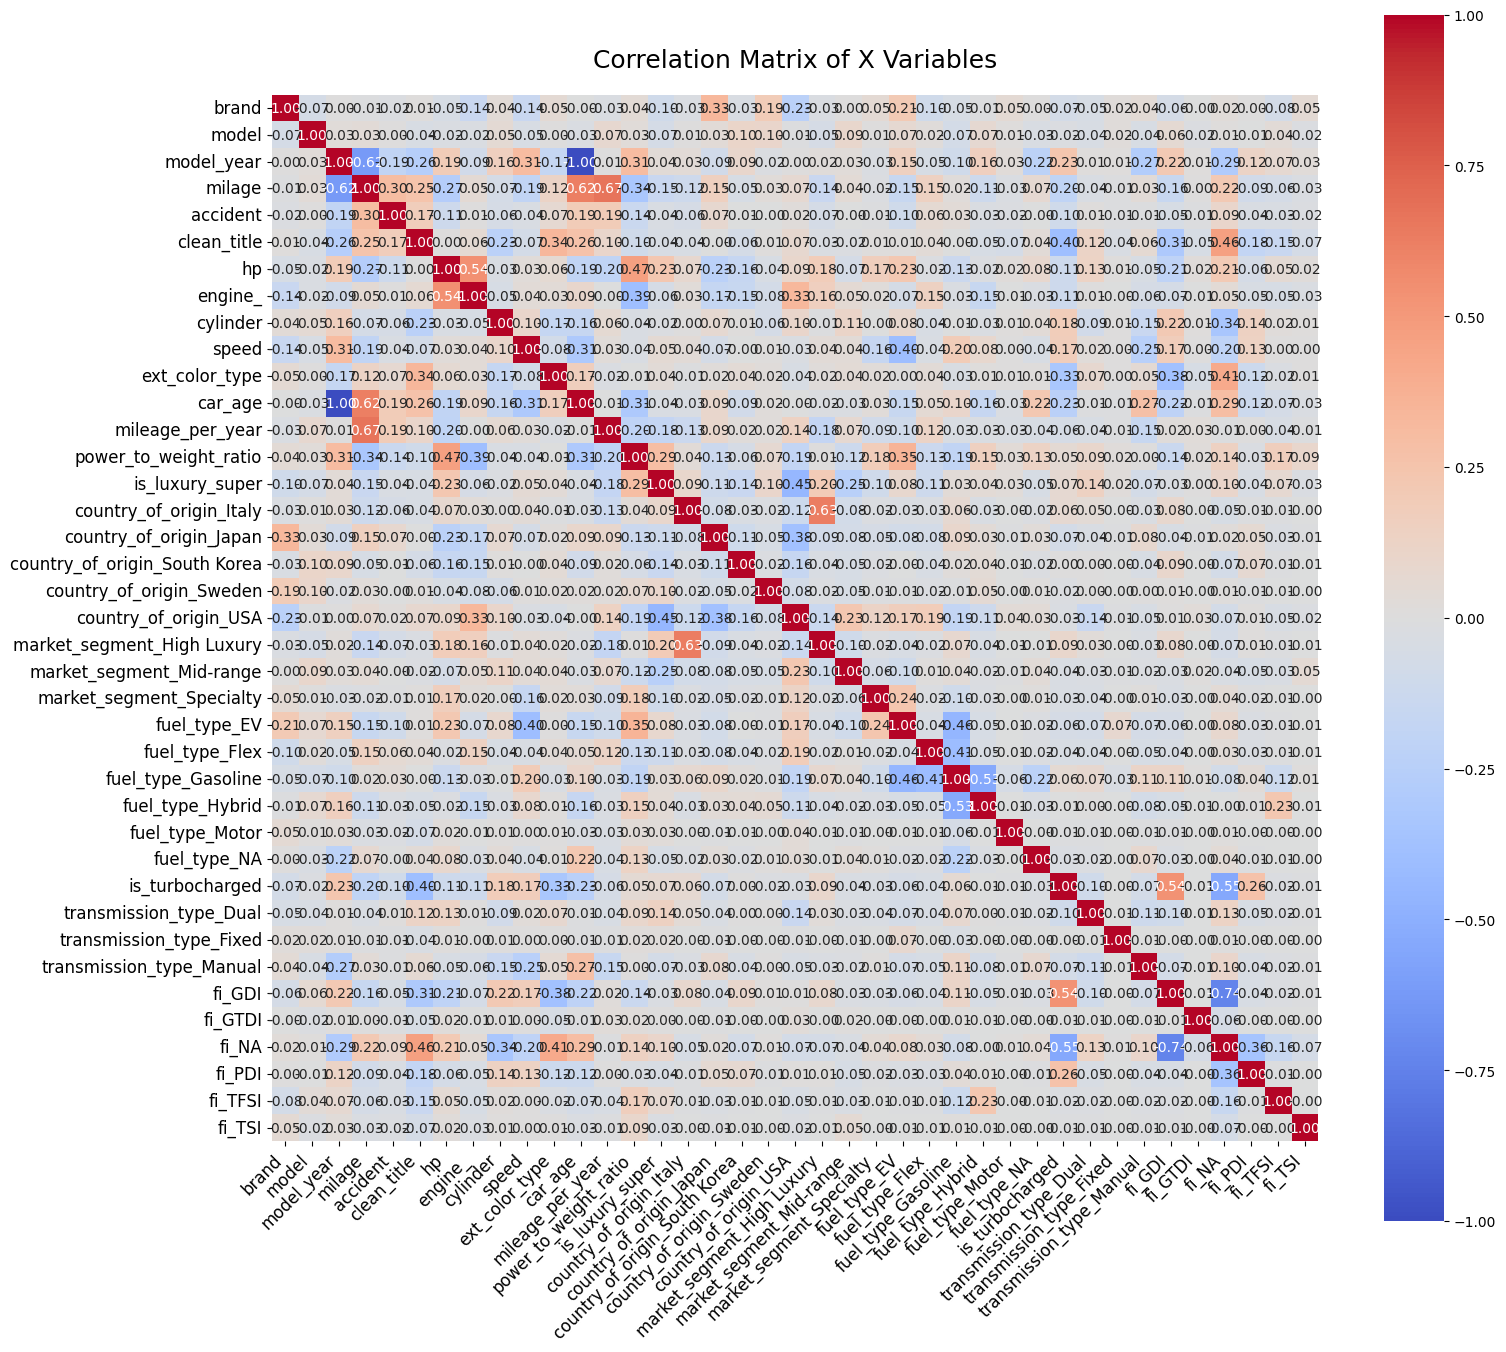

In [77]:
corr_matrix = X_selected.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    square=True, 
    annot_kws={"size": 10}
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Add a title
plt.title('Correlation Matrix of X Variables', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

In [78]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_results = calculate_vif(X_selected)
print(vif_results)


                         Variable         VIF
0                           brand    1.504817
1                           model    1.121677
2                      model_year  234.923075
3                          milage    6.637027
4                        accident    1.124591
5                     clean_title    1.541506
6                              hp    7.779245
7                         engine_    7.379022
8                        cylinder    1.293066
9                           speed    1.615726
10                 ext_color_type    1.321451
11                        car_age   14.263450
12               mileage_per_year    4.016627
13          power_to_weight_ratio    6.903015
14                is_luxury_super    2.048242
15        country_of_origin_Italy    1.734036
16        country_of_origin_Japan    1.763249
17  country_of_origin_South Korea    1.356155
18       country_of_origin_Sweden    1.132086
19          country_of_origin_USA    2.742689
20     market_segment_High Luxury 

### Multicollinearity analysis
- From correlation matrix - car_age and model_year are perfectly correlated (negative relationship), other strong single correlations are milage and mileage_per_year and mileage and car_age
- Highly multicollinear variables found using VIF (model_year, car_age etc.)
- We will remove iteratively until we don't have any more multicollinear variables

In [79]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

X_selected = add_constant(X_selected)

# Iteratively remove vars with high VIF
threshold = 10
while True:
    vif_data = calculate_vif(X_selected)
    max_vif = vif_data['VIF'].max()
    if max_vif > threshold:
        # remove feature with the highest
        max_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        X_selected = X_selected.drop(columns=[max_feature])
        print(f"Removed {max_feature} with VIF {max_vif:.2f}")
    else:
        break

/Users/huzihao/Documents/Postgraduate/mt2/FN6809/project/FN6809/venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/huzihao/Documents/Postgraduate/mt2/FN6809/project/FN6809/venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removed model_year with VIF inf
Removed const with VIF 237.14
Removed hp with VIF 57.41
Removed speed with VIF 34.29
Removed fi_NA with VIF 31.72
Removed fuel_type_Gasoline with VIF 24.08
Removed ext_color_type with VIF 21.91
Removed milage with VIF 15.95


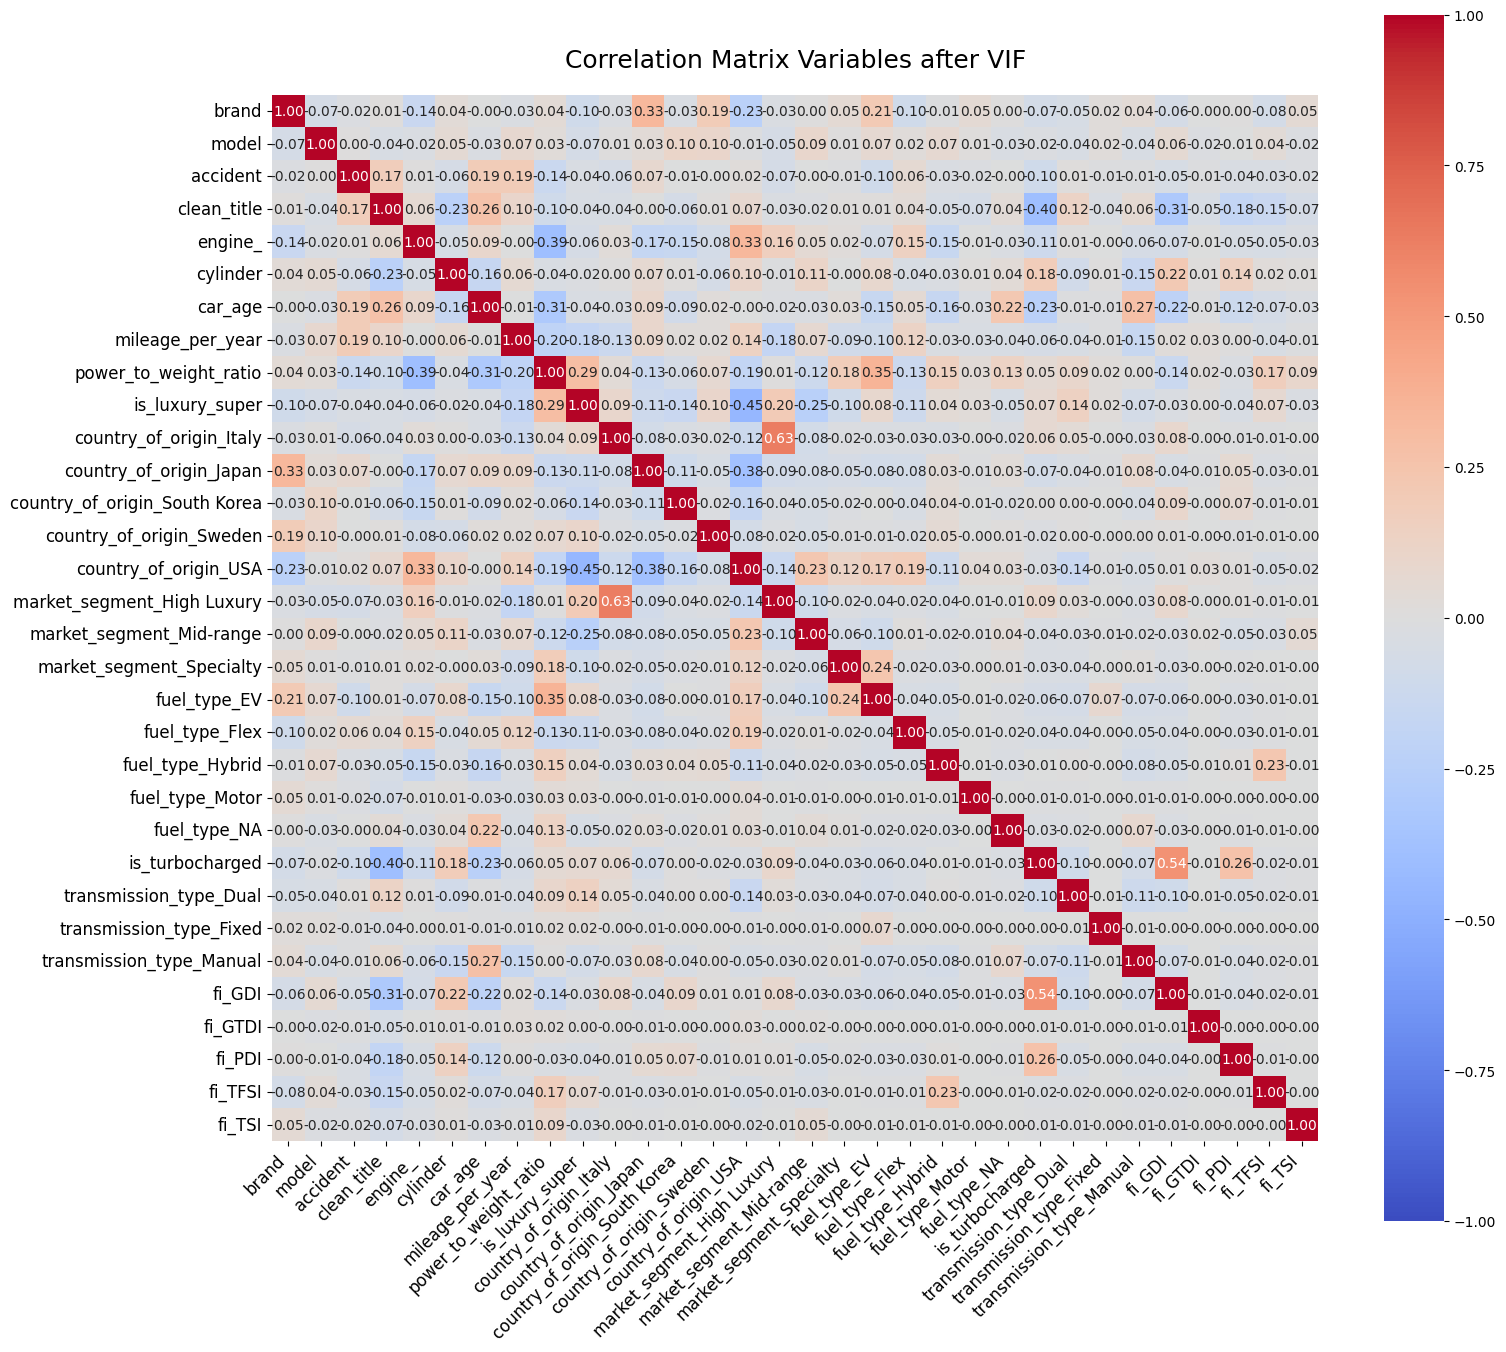

In [80]:
X_selected_refined = X_selected
corr_matrix = X_selected_refined.corr()

plt.figure(figsize=(16, 14))

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    square=True, 
    annot_kws={"size": 10} 
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Matrix Variables after VIF', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

In [81]:
X_selected_refined = X_selected
# Refit with new X vars
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
vif_results = calculate_vif(X_selected_refined)


print(vif_results)

                         Variable       VIF
0                           brand  4.130465
1                           model  4.160450
2                        accident  1.471991
3                     clean_title  8.203533
4                         engine_  7.659014
5                        cylinder  3.968511
6                         car_age  4.619028
7                mileage_per_year  4.073521
8           power_to_weight_ratio  8.696347
9                 is_luxury_super  3.593075
10        country_of_origin_Italy  1.761500
11        country_of_origin_Japan  2.050221
12  country_of_origin_South Korea  1.261833
13       country_of_origin_Sweden  1.128964
14          country_of_origin_USA  4.002903
15     market_segment_High Luxury  1.917827
16       market_segment_Mid-range  1.497117
17       market_segment_Specialty  1.151681
18                   fuel_type_EV  1.554794
19                 fuel_type_Flex  1.115332
20               fuel_type_Hybrid  1.199958
21                fuel_type_Moto

In [82]:
model_refined = LinearRegressionSPModel(X_selected_refined, y)

# Print the summary of the refined model
print(model_refined.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     48.29
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          4.09e-255
Time:                        22:17:05   Log-Likelihood:                -50225.
No. Observations:                4009   AIC:                         1.005e+05
Df Residuals:                    3976   BIC:                         1.007e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Post VIF Model Analysis
- Model still bad, with many variables statistically significant and model statistically significant but explained variance still very low
- We shall conduct residue analysis to try to pinpoint other errors in judgement

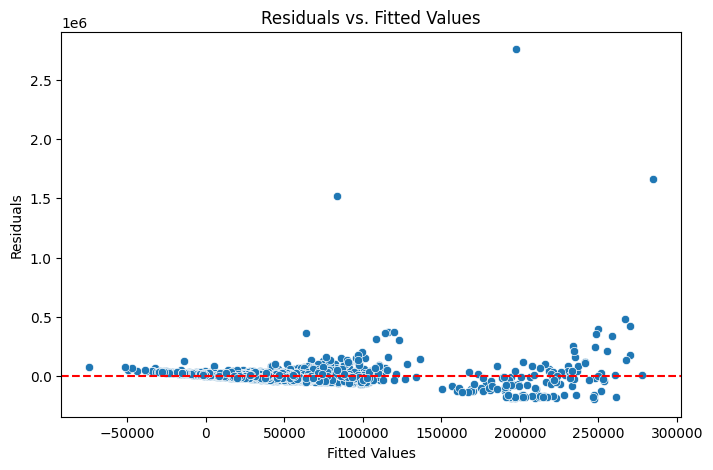

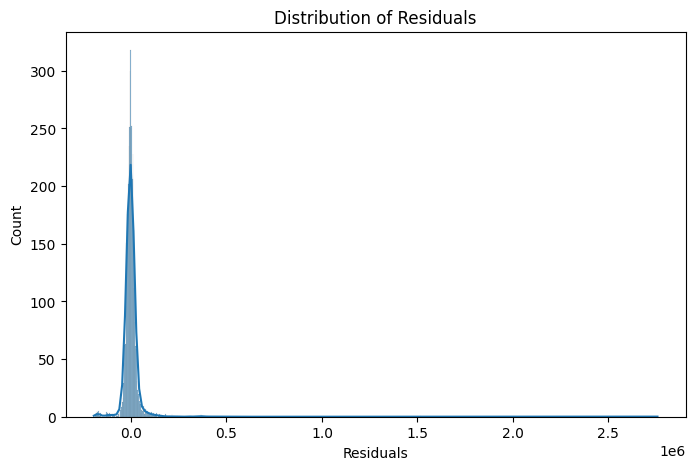

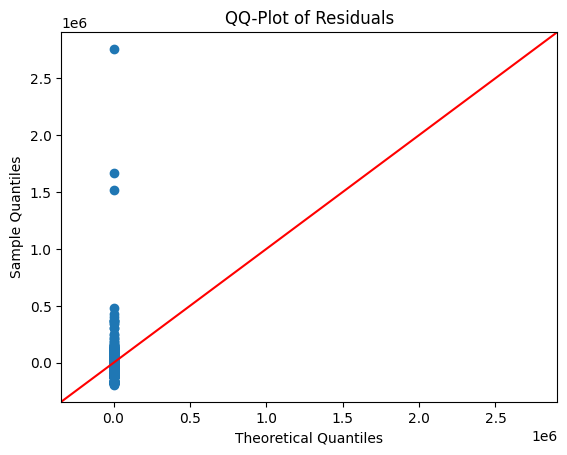

In [83]:
# Plotting residuals!
model_refined.plot_residuals()

## Residual Analysis

### QQ plot
- In a well-fitted model, QQ plot should show all errors along the red line
- Shows extreme outliers from the predictions

### Distribution of residuals
- Extremely right skewed, once again validating that there are extreme outliers
- In theory, a well fitted model should have residues should be distributed around 0

### Residual vs Fitted Values
- Widening of spread, heteroscedasticity issues?
- Once again, clear outliers
- And why are there negative predictions for price?

We next dive into the negative predictions and what's wrong with them

In [84]:
negative_fitted = model_refined.get_model().fittedvalues[model.fittedvalues < 0]
print(negative_fitted)

print(df.loc[negative_fitted.index])

7       -3086.690676
21     -37972.197671
31      -9791.529989
33       -562.778053
35     -10836.681746
            ...     
3970    -1978.418079
3973    -2157.676551
3974   -27739.112509
3983   -15124.447754
3985   -15093.957769
Length: 317, dtype: float64
      brand  model  model_year    milage  accident  clean_title    price  \
7         4    127        2001  242000.0         0            1   7300.0   
21        9   1446        2000  133510.0         0            1   4500.0   
31       11   1336        2006  300183.0         1            1  10900.0   
33       24   1601        2011  171000.0         0            1   5999.0   
35       22   1151        2017  119000.0         0            1  15900.0   
...     ...    ...         ...       ...       ...          ...      ...   
3970     14    580        2016  101387.0         1            1  16000.0   
3973     10   1705        2013  115872.0         0            1   9500.0   
3974      9    524        2011  135603.0         0       

### Negative value analysis
- Negative predictions are not caused by faulty data
- We can try to log the price value to ensure that price predicted is non negative
- Might also solve the issues with high variance and outliers

In [85]:

y_log = np.log1p(y)
model_log_y = LinearRegressionSPModel(X_selected_refined, y_log)
print(model_log_y.summary())
# predictions = np.expm1(model_log_y.get_model().fittedvalues)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     397.5
Date:                Thu, 24 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:17:06   Log-Likelihood:                -2160.7
No. Observations:                4009   AIC:                             4387.
Df Residuals:                    3976   BIC:                             4595.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### log y = Xbeta + e
- $R^2$ significantly improved 
- Still some statistically insignificant variables 

Check for important features
- We'll utilise standardised beta coefficient check

In [86]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_selected)
y_standardized = scaler.fit_transform(y_log.values.reshape(-1, 1)).flatten()

# Fit the standardized model using statsmodels
X_standardized = add_constant(X_standardized)
model_standardized = OLS(y_standardized, X_standardized).fit()

# Get the standardized beta coefficients
standardized_betas = model_standardized.params

In [87]:
beta_df = pd.DataFrame({ 'Var': ['Intercept'] + list(X_selected.columns), 'std b': standardized_betas})
beta_df.sort_values(by='std b', key=abs, ascending=False, inplace=True)
print(beta_df)

                              Var         std b
7                         car_age -6.075025e-01
5                         engine_  4.155666e-01
8                mileage_per_year -2.330896e-01
9           power_to_weight_ratio  1.668299e-01
16     market_segment_High Luxury  1.420971e-01
1                           brand  1.219136e-01
12        country_of_origin_Japan -1.028739e-01
27       transmission_type_Manual  1.018415e-01
10                is_luxury_super  9.298492e-02
28                         fi_GDI  7.991376e-02
19                   fuel_type_EV -7.051591e-02
13  country_of_origin_South Korea -7.009473e-02
14       country_of_origin_Sweden -6.654616e-02
15          country_of_origin_USA -5.904409e-02
23                   fuel_type_NA  5.698193e-02
3                        accident -5.661042e-02
17       market_segment_Mid-range -5.312378e-02
21               fuel_type_Hybrid  4.153165e-02
30                         fi_PDI  3.928692e-02
20                 fuel_type_Flex -3.855

### Standardised beta coefficient check
- from strongest feature to lowest 
- matches our p-value from the model summary provided

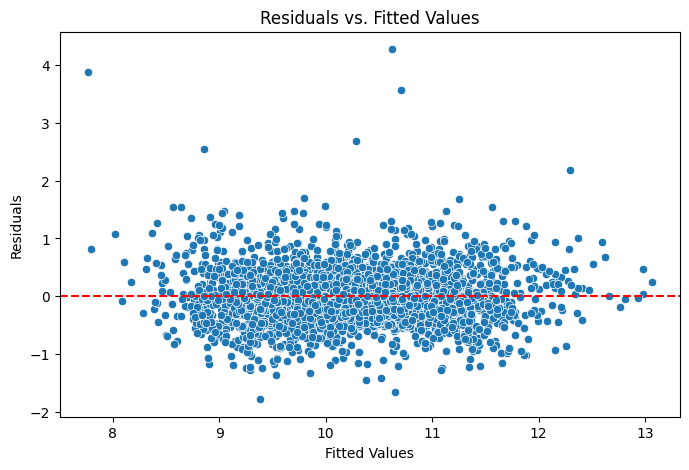

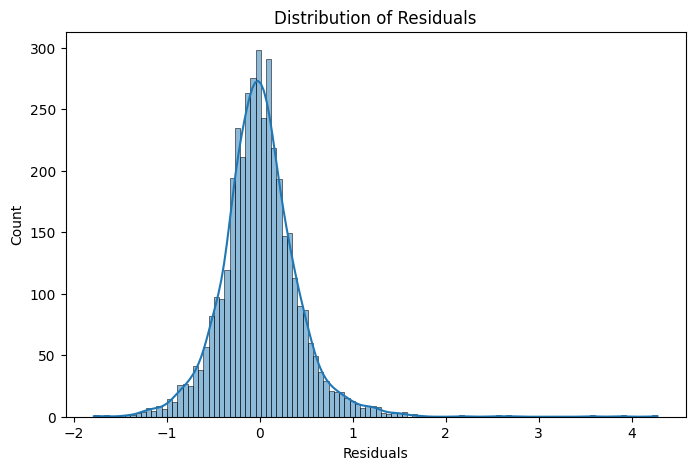

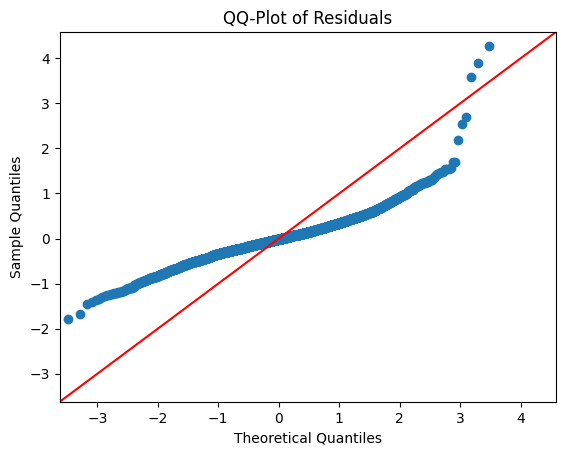

In [88]:
model_log_y.plot_residuals()

## Model Selection

#### Forward Selection

In [89]:
class ForwardSelection:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.selected_features = []
        self.remaining_features = list(X.columns)
        self.model = None

    def calculate_partial_f(self, X_current, X_new_var, y):
        # Full model with the new variable
        X_full = add_constant(pd.concat([X_current, X_new_var], axis=1))
        full_model = OLS(y, X_full).fit()
        
        # Restricted model without the new variable
        X_restricted = add_constant(X_current)
        restricted_model = OLS(y, X_restricted).fit()
        
        # Compute partial F-statistic
        num_vars_added = X_new_var.shape[1]
        num_obs = len(y)
        
        # Calculate the difference in RSS (Residual Sum of Squares)
        RSS_full = np.sum(full_model.resid ** 2)
        RSS_restricted = np.sum(restricted_model.resid ** 2)
        
        # Partial F-statistic formula
        partial_f = ((RSS_restricted - RSS_full) / num_vars_added) / (RSS_full / (num_obs - len(X_full.columns)))
        
        return partial_f, full_model

    def forward_select(self, threshold=0.05):
        # Step 1: Start by adding the feature with the highest correlation with y
        if not self.selected_features:  # Check if no features have been selected yet
            correlations = self.X.corrwith(self.y)  # Correlation of each feature with y
            best_feature = correlations.idxmax()  # Feature with the highest correlation
            self.selected_features.append(best_feature)
            self.remaining_features.remove(best_feature)
            X_current = self.X[[best_feature]]
            self.model = OLS(self.y, add_constant(X_current)).fit()  # Fit model with the first feature
            print(f"Initial feature added: {best_feature}, correlation with y: {correlations[best_feature]}")
        
        # Step 2: Continue adding features based on the highest partial F-statistic
        while self.remaining_features:
            best_feature = None
            best_f_stat = -np.inf
            best_model = None

            # Check each remaining variable for partial F-statistic
            for feature in self.remaining_features:
                X_current = self.X[self.selected_features]

                X_new_var = self.X[[feature]]
                
                # Calculate partial F-statistic for adding this feature
                partial_f_stat, model = self.calculate_partial_f(X_current, X_new_var, self.y)

                # Select the feature with the highest partial F-statistic
                if partial_f_stat > best_f_stat:
                    best_feature = feature
                    best_f_stat = partial_f_stat
                    best_model = model

            # Add the feature with the highest F-statistic, if significant
            if best_feature and (best_model.pvalues[best_feature] < threshold):
                self.selected_features.append(best_feature)
                self.remaining_features.remove(best_feature)
                self.model = best_model  # Update the model with the selected feature
                print(f"Added: {best_feature}, Partial F-statistic: {best_f_stat}")
            else:
                break  # Stop if no significant variable is found

        return self.model


In [90]:
X_train, X_validation, y_train, y_validation = train_test_split(X_selected_refined, y_log, test_size=0.5, random_state=42)
# Apply forward selection on the training set
forward_selector = ForwardSelection(X_train, y_train)
optimal_model = forward_selector.forward_select()

# Print the summary of the selected model (trained on the training set)
print(optimal_model.summary())

/Users/huzihao/Documents/Postgraduate/mt2/FN6809/project/FN6809/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/huzihao/Documents/Postgraduate/mt2/FN6809/project/FN6809/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Initial feature added: power_to_weight_ratio, correlation with y: 0.2953413409220871
Added: car_age, Partial F-statistic: 1261.7308621493783
Added: engine_, Partial F-statistic: 776.7471563970105
Added: mileage_per_year, Partial F-statistic: 537.8704337921251
Added: market_segment_High Luxury, Partial F-statistic: 135.9439614445593
Added: is_luxury_super, Partial F-statistic: 84.96128160790772
Added: fi_GDI, Partial F-statistic: 58.85574079140236
Added: brand, Partial F-statistic: 51.18182267214814
Added: fuel_type_EV, Partial F-statistic: 49.595223147499894
Added: transmission_type_Manual, Partial F-statistic: 34.90631920374366
Added: accident, Partial F-statistic: 27.00251472449493
Added: fi_PDI, Partial F-statistic: 20.029039760201726
Added: fuel_type_Flex, Partial F-statistic: 17.53438422415573
Added: fuel_type_NA, Partial F-statistic: 16.409736547209416
Added: country_of_origin_Japan, Partial F-statistic: 13.276967558277176
Added: country_of_origin_South Korea, Partial F-statistic

**Notice that $(p-1)$ is the number of predictors!**

The calculations of AIC and BIC are as follows:
$$
\text{AIC} = n \cdot \log\left(\frac{\text{SSE}}{n}\right) + 2p + n \cdot \log(2\pi) + n
$$
$$
\text{BIC} = n \cdot \log\left(\frac{\text{SSE}}{n}\right) + p \cdot \log(n) + n \cdot \log(2\pi) + n
$$

The Mallows' $C_p$ statistic is defined as:
$$
C_p = \frac{SSE_p}{s^2_{n\text{Candidate}}} + 2p - n
$$

Where:
- $SSE_p$ is the error sum of squares in a model containing $p$ regression parameters, including $\beta_0$ (or $p - 1$ of the $n_{\text{Candidate}}$ candidate variables).
- $n$ is equal to the sum of the frequencies (or the number of rows if frequencies are not specified).
- $s^2_{n\text{Candidate}}$ is the error mean square from the model with all $n_{\text{Candidate}}$ variables in the model.

Hocking (1972) and Draper and Smith (1981, pp. 296−302) discuss these criteria.


#### TODO

In [91]:
def calculate_PRESSp(X_train, y_train, selected_features):
    n = len(y_train)  # Number of observations
    PRESS = 0.0  # Initialize PRESS

    # Select only the relevant features from the DataFrame
    X_train_selected = X_train[selected_features]
    
    # Assert that the selected features are indeed present in X_train
    assert set(selected_features).issubset(X_train.columns), "Some selected features are not in X_train"
    
    # Assert that y_train is a pandas Series
    assert isinstance(y_train, pd.Series), "y_train should be a pandas Series"
    
    # Check dimensions
    assert X_train_selected.shape[0] == n, f"Expected {n} rows in X_train_selected, but got {X_train_selected.shape[0]}"
    assert y_train.shape[0] == n, f"Expected {n} rows in y_train, but got {y_train.shape[0]}"

    for i in range(n):
        # Exclude the i-th observation using pandas
        X_train_i = X_train_selected.drop(index=X_train_selected.index[i])
        y_train_i = y_train.drop(index=y_train.index[i])

        # Assert that the shapes after dropping are consistent
        assert X_train_i.shape[0] == n - 1, f"Expected {n - 1} rows in X_train_i, but got {X_train_i.shape[0]}"
        assert y_train_i.shape[0] == n - 1, f"Expected {n - 1} rows in y_train_i, but got {y_train_i.shape[0]}"
        
        # Fit the forward-selected model on the remaining data
        if selected_features:  # Ensure selected_features is not empty
            model_i = OLS(y_train_i, add_constant(X_train_i)).fit()

            # Prepare the excluded observation with constant
            x_pred_i = add_constant(X_train_selected.iloc[i:i + 1])  # Add constant for prediction
            
            # Check dimensions before prediction
            assert x_pred_i.shape[1] == model_i.params.shape[0], \
                f"Prediction input shape {x_pred_i.shape} does not match model parameters shape {model_i.params.shape}"

            # Predict the excluded observation
            y_pred_i = model_i.predict(x_pred_i.values)

            # Update PRESS
            PRESS += (y_train.iloc[i] - y_pred_i) ** 2

    return PRESS


In [92]:
def calculate_train_criteria(model, n, X_train, y_train,selected_features):

    # Extract parameters
    # number of parameters including intercept!!!
    p = model.params.shape[0]  


    residuals = model.resid
    SSE = np.sum(residuals ** 2)  # Sum of squared errors
    MSE = SSE / (n - p) if (n - p) > 0 else np.nan  # Mean squared error
    R_squared = model.rsquared
    adj_R_squared = model.rsquared_adj
    AIC = model.aic
    BIC = model.bic
    
    # Calculate Mallows' Cp
    full_model = OLS(y_train, add_constant(X_train)).fit()
    SSE_full = np.sum(full_model.resid ** 2)  # SSE from full model
    s2_nCandidate = SSE_full / (n - full_model.params.shape[0])  # Mean square error from the full model

    Cp = (SSE / s2_nCandidate) - n + 2 * p

    # Calculate PRESS
    # PRESS = calculate_PRESSp(X_train, y_train, selected_features)

    return {
        'R_squared': R_squared,
        'Adjusted R_squared': adj_R_squared,
        'Mallows_Cp': Cp,
        'AIC': AIC,
        'BIC': BIC,
        'SSE': SSE,
        # 'PRESS':PRESS
    }


def calculate_validation_criteria(model,X_train, y_train, X_val, y_val, selected_features):
    # Restrict the validation set to the selected features
    X_val_restricted = X_val[selected_features]
    
    # Predict on the restricted validation set
    predictions = model.predict(add_constant(X_val_restricted))
    
    # Calculate residuals
    residuals = y_val - predictions
    n = len(y_val)  # number of observations in the validation set
    p = model.params.shape[0]  # number of parameters including intercept

    # Calculate metrics
    SSE = np.sum(residuals**2)  # Sum of squared errors
    # Use n - p for MSE calculation
    MSE = SSE / (n - p) if (n - p) > 0 else np.nan  # Handle case when n-p is non-positive
    R_squared = 1 - (SSE / np.sum((y_val - np.mean(y_val))**2))
    adj_R_squared = 1 - (1 - R_squared) * (n - 1) / (n - p - 1)  # Adjusted for degrees of freedom
    # Calculate AIC and BIC using the own formula
    AIC_own = n * np.log(SSE / n) + 2 * p+ n + n*np.log(2*np.pi) if (n - p) > 0 else np.nan  # Avoid division by zero
    BIC_own = n * np.log(SSE / n) + p * np.log(n) + n + n*np.log(2*np.pi) if (n - p) > 0 else np.nan  # Avoid division by zero
    
    # Calculate Mallows' Cp
    full_model = OLS(y_train, add_constant(X_train)).fit()
    predictions_cp = full_model.predict(add_constant(X_val))

    SSE_full = np.sum((predictions_cp - y_val)** 2)  # SSE from full model
    s2_nCandidate = SSE_full / (n - full_model.params.shape[0])  # Mean square error from the full model

    Cp = (SSE / s2_nCandidate) - n + 2 * p


    # Calculate PRESS (Prediction Error Sum of Squares)
    # PRESS = calculate_PRESSp(X_train, y_train, selected_features)

    return {
        'R_squared': R_squared,
        'Adjusted R_squared': adj_R_squared,
        'Mallows_Cp': Cp,
        'AIC': AIC_own,
        'BIC': BIC_own,
        'SSE': SSE
        # 'PRESS':PRESS
    }



In [93]:
# Calculate the criteria for the train set
n = len(y_train)  # number of observations in the training set
train_criteria_results = calculate_train_criteria(optimal_model, n,X_train,y_train,forward_selector.selected_features)

# Convert results to DataFrame for easier viewing
train_criteria_df = pd.DataFrame.from_dict(train_criteria_results, orient='index', columns=['Value'])
print(train_criteria_df)

                          Value
R_squared              0.765335
Adjusted R_squared     0.762610
Mallows_Cp            28.266874
AIC                 2149.927552
BIC                 2284.397163
SSE                  334.919244


In [94]:
# Calculate the criteria for the validation set
validation_criteria_results = calculate_validation_criteria(optimal_model,X_train, y_train, X_validation, y_validation, forward_selector.selected_features)

# Convert results to DataFrame for easier viewing
validation_criteria_df = pd.DataFrame.from_dict(validation_criteria_results, orient='index', columns=['Value'])
print(validation_criteria_df)

                          Value
R_squared              0.749456
Adjusted R_squared     0.746419
Mallows_Cp            34.474032
AIC                 2339.030744
BIC                 2473.512328
SSE                  368.036088


#### Backward Selection

In [95]:
class BackwardSelection:
    def __init__(self, significance_level=0.05):
        self.significance_level = significance_level
        self.selected_features = None  # To store the final selected features
        
    def fit(self, X_train, y_train):
        X_train = add_constant(X_train)  # Add a constant (intercept)
        self.X_train = X_train
        self.y_train = y_train
        self.model = self._backward_elimination(X_train, y_train)
    
    def _partial_f_test(self, full_model, reduced_model):
        # Degrees of freedom for the full and reduced models
        df_full = full_model.df_resid
        df_reduced = reduced_model.df_resid
        
        # Residual sum of squares (RSS) for both models
        rss_full = sum(full_model.resid ** 2)
        rss_reduced = sum(reduced_model.resid ** 2)
        
        # Check for valid degrees of freedom and RSS difference
        if (df_reduced - df_full) == 0 or (rss_reduced - rss_full) <= 0:
            return np.nan  # Return NaN if invalid

        # Calculate F-statistic
        numerator = (rss_reduced - rss_full) / (df_reduced - df_full)
        denominator = rss_full / df_full
        
        if denominator == 0:
            return np.nan  # Avoid division by zero in denominator
        
        f_stat = numerator / denominator

        # Return the p-value of the F-statistic using scipy's f-distribution
        return 1 - f.cdf(f_stat, df_reduced - df_full, df_full)
    
    def _backward_elimination(self, X, y):
        selected_vars = list(X.columns)  # Get all column names (features)
        while len(selected_vars) > 0:
            full_model = OLS(y, X[selected_vars]).fit()
            f_p_values = {}
            for var in selected_vars:
                reduced_vars = selected_vars.copy()
                reduced_vars.remove(var)
                reduced_model = OLS(y, X[reduced_vars]).fit()
                f_p_value = self._partial_f_test(full_model, reduced_model)
                f_p_values[var] = f_p_value
            
            # Exclude NaN values from the F-test p-values
            f_p_values = {k: v for k, v in f_p_values.items() if not np.isnan(v)}
            
            if not f_p_values:
                break  # Exit if all p-values are NaN

            max_p_var, max_p_value = max(f_p_values.items(), key=lambda item: item[1])
            if max_p_value > self.significance_level:
                print(f"Removing variable {max_p_var} with partial F-test p-value {max_p_value}")
                selected_vars.remove(max_p_var)
            else:
                break
        
        print(f"Final model includes variables: {selected_vars}")
        self.selected_features = [var for var in selected_vars if var != 'const']  # Remove 'const' and store final selected features
        return OLS(y, add_constant(X[selected_vars])).fit()
    
    def summary(self):
        return self.model.summary()


In [96]:
# Example usage:
bs = BackwardSelection(significance_level=0.05)
bs.fit(X_train, y_train)
print(bs.summary())

Removing variable clean_title with partial F-test p-value 0.821078630806601
Removing variable fi_GTDI with partial F-test p-value 0.6599082437238177
Removing variable is_turbocharged with partial F-test p-value 0.6551631537269249
Removing variable market_segment_Specialty with partial F-test p-value 0.22160043849758204
Removing variable fuel_type_Motor with partial F-test p-value 0.17112853588554988
Removing variable model with partial F-test p-value 0.09294097183911199
Removing variable country_of_origin_Italy with partial F-test p-value 0.08221489033071039
Removing variable cylinder with partial F-test p-value 0.057546512616808654
Final model includes variables: ['const', 'brand', 'accident', 'engine_', 'car_age', 'mileage_per_year', 'power_to_weight_ratio', 'is_luxury_super', 'country_of_origin_Japan', 'country_of_origin_South Korea', 'country_of_origin_Sweden', 'country_of_origin_USA', 'market_segment_High Luxury', 'market_segment_Mid-range', 'fuel_type_EV', 'fuel_type_Flex', 'fuel

In [97]:
# Calculate the criteria for the train set
n = len(y_train)  # number of observations in the training set
train_criteria_results = calculate_train_criteria(bs.model, n,X_train,y_train,bs.selected_features)

# Convert results to DataFrame for easier viewing
train_criteria_df = pd.DataFrame.from_dict(train_criteria_results, orient='index', columns=['Value'])
print(train_criteria_df)

                          Value
R_squared              0.765335
Adjusted R_squared     0.762610
Mallows_Cp            30.266874
AIC                 2149.927552
BIC                 2284.397163
SSE                  334.919244


In [98]:
# Calculate the criteria for the validation set
validation_criteria_results = calculate_validation_criteria(bs.model,X_train, y_train, X_validation, y_validation, bs.selected_features)

# Convert results to DataFrame for easier viewing
validation_criteria_df = pd.DataFrame.from_dict(validation_criteria_results, orient='index', columns=['Value'])
print(validation_criteria_df)

                          Value
R_squared              0.749456
Adjusted R_squared     0.746291
Mallows_Cp            36.474032
AIC                 2341.030744
BIC                 2481.115727
SSE                  368.036088


#### Stepwise Selection

In [99]:
class StepwiseSelection:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.selected_features = []
        self.remaining_features = list(X.columns)
        self.model = None

    def calculate_partial_f(self, X_current, X_new_var, y):
        # Full model with the new variable
        X_full = add_constant(pd.concat([X_current, X_new_var], axis=1))
        full_model = OLS(y, X_full).fit()
        
        # Restricted model without the new variable
        X_restricted = add_constant(X_current)
        restricted_model = OLS(y, X_restricted).fit()
        
        # Compute partial F-statistic
        num_vars_added = X_new_var.shape[1]
        num_obs = len(y)
        
        # Calculate the difference in RSS (Residual Sum of Squares)
        RSS_full = np.sum(full_model.resid ** 2)
        RSS_restricted = np.sum(restricted_model.resid ** 2)
        
        # Partial F-statistic formula
        partial_f = ((RSS_restricted - RSS_full) / num_vars_added) / (RSS_full / (num_obs - len(X_full.columns)))
        
        return partial_f, full_model

    def calculate_remove_f(self, X_current, feature_to_remove, y):
        # Full model without the variable to be removed
        X_full = add_constant(X_current.drop(columns=feature_to_remove))
        full_model = OLS(y, X_full).fit()
        
        # Restricted model with the variable to be removed
        X_restricted = add_constant(X_current)
        restricted_model = OLS(y, X_restricted).fit()
        
        # Compute partial F-statistic for removal
        num_vars_removed = 1  # We are removing one variable
        num_obs = len(y)
        
        RSS_full = np.sum(full_model.resid ** 2)
        RSS_restricted = np.sum(restricted_model.resid ** 2)
        
        # Partial F-statistic formula
        partial_f_remove = ((RSS_restricted - RSS_full) / num_vars_removed) / (RSS_full / (num_obs - len(X_current.columns)))
        
        return partial_f_remove

    def stepwise_select(self, entry_threshold=0.05, removal_threshold=0.05):
        # Step 1: Start by adding the feature with the highest correlation with y
        if not self.selected_features:  # Check if no features have been selected yet
            correlations = self.X.corrwith(self.y)  # Correlation of each feature with y
            best_feature = correlations.idxmax()  # Feature with the highest correlation
            self.selected_features.append(best_feature)
            self.remaining_features.remove(best_feature)
            X_current = self.X[[best_feature]]
            self.model = OLS(self.y, add_constant(X_current)).fit()  # Fit model with the first feature
            print(f"Initial feature added: {best_feature}, correlation with y: {correlations[best_feature]}")

        # Step 2: Continue adding features based on the highest partial F-statistic
        no_change = False  # Flag to detect whether the selection has stalled
        while self.remaining_features and not no_change:
            added_feature = False
            removed_feature = False

            # Add features
            best_feature = None
            best_f_stat = -np.inf
            best_model = None

            # Check each remaining variable for partial F-statistic
            for feature in self.remaining_features:
                X_current = self.X[self.selected_features]

                X_new_var = self.X[[feature]]
                
                # Calculate partial F-statistic for adding this feature
                partial_f_stat, model = self.calculate_partial_f(X_current, X_new_var, self.y)

                # Select the feature with the highest partial F-statistic
                if partial_f_stat > best_f_stat:
                    best_feature = feature
                    best_f_stat = partial_f_stat
                    best_model = model

            # Add the feature with the highest F-statistic, if significant
            if best_feature and (best_model.pvalues[best_feature] < entry_threshold):
                self.selected_features.append(best_feature)
                self.remaining_features.remove(best_feature)
                self.model = best_model  # Update the model with the selected feature
                print(f"Added: {best_feature}, Partial F-statistic: {best_f_stat}")
                added_feature = True

            # Step 3: Check for variables to remove
            for feature in self.selected_features[:]:  # Copy list to avoid modification while iterating
                X_current = self.X[self.selected_features]
                
                # Calculate partial F-statistic for removing this feature
                f_stat_remove = self.calculate_remove_f(X_current, feature, self.y)
                
                # Remove feature if it's not significant
                if self.model.pvalues[feature] > removal_threshold:
                    print(f"Removed: {feature}, Partial F-statistic for removal: {f_stat_remove}")
                    self.selected_features.remove(feature)
                    self.model = OLS(self.y, add_constant(X_current.drop(columns=feature))).fit()  # Update model after removal
                    removed_feature = True

            # If no feature is added or removed, stop the loop
            if not added_feature and not removed_feature:
                no_change = True

        return self.model


In [100]:
step_selector = StepwiseSelection(X_train, y_train)
step_optimal_model = step_selector.stepwise_select()

# Print the summary of the selected model (trained on the training set)
print(step_optimal_model.summary())

Initial feature added: power_to_weight_ratio, correlation with y: 0.2953413409220871
Added: car_age, Partial F-statistic: 1261.7308621493783
Added: engine_, Partial F-statistic: 776.7471563970105


/Users/huzihao/Documents/Postgraduate/mt2/FN6809/project/FN6809/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/huzihao/Documents/Postgraduate/mt2/FN6809/project/FN6809/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Added: mileage_per_year, Partial F-statistic: 537.8704337921251
Added: market_segment_High Luxury, Partial F-statistic: 135.9439614445593
Added: is_luxury_super, Partial F-statistic: 84.96128160790772
Added: fi_GDI, Partial F-statistic: 58.85574079140236
Added: brand, Partial F-statistic: 51.18182267214814
Added: fuel_type_EV, Partial F-statistic: 49.595223147499894
Added: transmission_type_Manual, Partial F-statistic: 34.90631920374366
Added: accident, Partial F-statistic: 27.00251472449493
Added: fi_PDI, Partial F-statistic: 20.029039760201726
Added: fuel_type_Flex, Partial F-statistic: 17.53438422415573
Added: fuel_type_NA, Partial F-statistic: 16.409736547209416
Added: country_of_origin_Japan, Partial F-statistic: 13.276967558277176
Added: country_of_origin_South Korea, Partial F-statistic: 17.721617706732953
Added: country_of_origin_Sweden, Partial F-statistic: 17.86288564472476
Added: country_of_origin_USA, Partial F-statistic: 16.0667534192543
Added: fi_TSI, Partial F-statistic:

In [101]:
# Calculate the criteria for the train set
n = len(y_train)  # number of observations in the training set
train_criteria_results = calculate_train_criteria(step_optimal_model, n,X_train,y_train,step_selector.selected_features)

# Convert results to DataFrame for easier viewing
train_criteria_df = pd.DataFrame.from_dict(train_criteria_results, orient='index', columns=['Value'])
print(train_criteria_df)

                          Value
R_squared              0.765335
Adjusted R_squared     0.762610
Mallows_Cp            28.266874
AIC                 2149.927552
BIC                 2284.397163
SSE                  334.919244


In [102]:
# Calculate the criteria for the validation set
validation_criteria_results = calculate_validation_criteria(step_optimal_model,X_train, y_train, X_validation, y_validation, step_selector.selected_features)

# Convert results to DataFrame for easier viewing
validation_criteria_df = pd.DataFrame.from_dict(validation_criteria_results, orient='index', columns=['Value'])
print(validation_criteria_df)

                          Value
R_squared              0.749456
Adjusted R_squared     0.746419
Mallows_Cp            34.474032
AIC                 2339.030744
BIC                 2473.512328
SSE                  368.036088
